In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn import preprocessing
import wfdb
import copy as cp
import scipy.signal as signal
import scipy.stats as stats
from sklearn import preprocessing
from tqdm import tqdm
import os
import pathlib
import re
import pandas as pd
import pickle
import csv
import statistics

In [2]:
import timeit

import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats("retina")

from sklearn.preprocessing import PolynomialFeatures

import sklearn.linear_model as skl_lm
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn import neighbors
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis 
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeRegressor 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.tree import export_graphviz
from sklearn.svm import SVC

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

import xgboost as xgb
from xgboost import XGBClassifier
from sklearn import metrics
from lightgbm import LGBMClassifier

import lightgbm
import lightgbm as lgb
from sklearn.preprocessing import LabelBinarizer

import catboost as cb
from catboost import CatBoostClassifier

C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
parent_path = str(pathlib.Path(os.getcwd()).parent)

rlist = []
records = os.path.normpath(parent_path + '/mit-bih-dataframes/subject_list.csv')
with open(records) as rfile:
    recordreader = csv.reader(rfile, delimiter=' ', quotechar='|')
    for row in recordreader:
        rlist.append(row[0])

In [11]:
performance_dict = {
    "Avg Accuracy": [],
    "Std Accuracy": [],
    "Sensitivity": [],
    "Specificity": [],
    "Precision": [],
    "F1 score": [],
    "Run time": [],
}

In [4]:
feature_dfs = {}
for record in tqdm(rlist):
    feature_dfs[record] = pd.read_csv(os.path.normpath(parent_path + '/mit-bih-time-features/'+record+'.csv'), index_col=0, dtype={'subjectID': str})

combined_features = pd.concat([feature_dfs[key][1:] for key in feature_dfs])

100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 32.22it/s]


In [5]:
X = combined_features[['mad']]
y = combined_features['mappedLabel'].map({"Non-Afib": 0, "Afib": 1})
groups = combined_features['subjectID'].astype('int64')

logo = LeaveOneGroupOut()
splits = list(logo.split(X, y, groups=groups))

In [6]:
# Logistic regression
start_time = timeit.default_timer()

logreg = LogisticRegression(solver='liblinear')

acc_score = []
Truth = []
Output = []

for train, test in tqdm(splits):
    X_train = X.iloc[train]
    y_train = y.iloc[train]

    X_test = X.iloc[test]
    y_test = y.iloc[test]

    logreg.fit(X_train, y_train)
    pred_values = logreg.predict(X_test)

    acc = accuracy_score(y_test, pred_values)
    acc_score.append(acc)

    Truth.extend(y_test.values.reshape(y_test.shape[0])) 
    Output.extend(pred_values)

elapsed = timeit.default_timer() - start_time

print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print("confusion matrix: ")

cm = confusion_matrix(Truth, Output)
print(cm)
print("classification report: ")
print(classification_report(Truth, Output))

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:02<00:00, 11.34it/s]


---Run time is 2.037384800147265 seconds ---

Accuracy of each fold: 
 [0.884894053315106, 0.8726337248810795, 0.984313725490196, 0.7839696799550814, 0.9589247581962065, 0.9237956204379562, 0.8561981618471195, 0.9377966934031756, 0.8830620855937311, 0.7575637468622011, 0.957801766437684, 0.8996025574563677, 0.8266884531590414, 0.9998467667790377, 0.2025935162094763, 0.6605847204438754, 0.936268829663963, 0.9926439972241499, 0.6341512877712432, 0.8979915433403806, 0.9032785210907976, 0.9081848384173966, 0.8548354532606501]
Avg accuracy: 0.848592369618953
Std of accuracy : 
0.16600189581069819
confusion matrix: 
[[90567 12318]
 [18603 66069]]
classification report: 
              precision    recall  f1-score   support

           0       0.83      0.88      0.85    102885
           1       0.84      0.78      0.81     84672

    accuracy                           0.84    187557
   macro avg       0.84      0.83      0.83    187557
weighted avg       0.84      0.84      0.83    187557



In [7]:
# Linear discriminant analysis
start_time = timeit.default_timer()

lda = LinearDiscriminantAnalysis()

acc_score = []
Truth = []
Output = []

for train, test in tqdm(splits):
    X_train = X.iloc[train]
    y_train = y.iloc[train]

    X_test = X.iloc[test]
    y_test = y.iloc[test]

    lda.fit(X_train, y_train)
    pred_values = lda.predict(X_test)

    acc = accuracy_score(y_test, pred_values)
    acc_score.append(acc)

    Truth.extend(y_test.values.reshape(y_test.shape[0])) 
    Output.extend(pred_values)

elapsed = timeit.default_timer() - start_time

print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print("confusion matrix: ")

cm = confusion_matrix(Truth, Output)
print(cm)
print("classification report: ")
print(classification_report(Truth, Output))

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 24.65it/s]


---Run time is 0.9444057999644428 seconds ---

Accuracy of each fold: 
 [0.8936431989063568, 0.8478788467139112, 0.9850678733031675, 0.8120437956204379, 0.9405853535987941, 0.9198053527980535, 0.833109168347904, 0.9443444098870519, 0.8435201928872815, 0.7827982560443916, 0.9253080362010686, 0.9153274580957318, 0.8149237472766885, 0.9992338338951885, 0.1174064837905237, 0.6163038839095177, 0.9465320311206754, 0.989174184594032, 0.6633542891908335, 0.8769820295983086, 0.8707997140230824, 0.9090909090909091, 0.8017363214213608]
Avg accuracy: 0.836911711752838
Std of accuracy : 
0.17933808935632162
confusion matrix: 
[[92696 10189]
 [23468 61204]]
classification report: 
              precision    recall  f1-score   support

           0       0.80      0.90      0.85    102885
           1       0.86      0.72      0.78     84672

    accuracy                           0.82    187557
   macro avg       0.83      0.81      0.82    187557
weighted avg       0.82      0.82      0.82    18755

In [8]:
# Quadratic discriminant analysis
start_time = timeit.default_timer()

qda = QuadraticDiscriminantAnalysis()

acc_score = []
Truth = []
Output = []

for train, test in tqdm(splits):
    X_train = X.iloc[train]
    y_train = y.iloc[train]

    X_test = X.iloc[test]
    y_test = y.iloc[test]

    qda.fit(X_train, y_train)
    pred_values = qda.predict(X_test)

    acc = accuracy_score(y_test, pred_values)
    acc_score.append(acc)

    Truth.extend(y_test.values.reshape(y_test.shape[0])) 
    Output.extend(pred_values)

elapsed = timeit.default_timer() - start_time

print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print("confusion matrix: ")

cm = confusion_matrix(Truth, Output)
print(cm)
print("classification report: ")
print(classification_report(Truth, Output))

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 60.86it/s]


---Run time is 0.38176399981603026 seconds ---

Accuracy of each fold: 
 [0.8939166097060834, 0.8470051451315407, 0.9850678733031675, 0.8130263896687254, 0.9389523929154628, 0.919610705596107, 0.8315400134498991, 0.9448354886233427, 0.8403857745629898, 0.78451578808297, 0.9202922254934032, 0.9161914636253672, 0.8133986928104575, 0.9992338338951885, 0.11630922693266833, 0.6143832693128468, 0.9475252441648734, 0.9887578070784178, 0.663861285743257, 0.8756606765327696, 0.8676335410070473, 0.9095439444276654, 0.7989097516656571]
Avg accuracy: 0.83611118016217
Std of accuracy : 
0.17947658084890092
confusion matrix: 
[[92796 10089]
 [23749 60923]]
classification report: 
              precision    recall  f1-score   support

           0       0.80      0.90      0.85    102885
           1       0.86      0.72      0.78     84672

    accuracy                           0.82    187557
   macro avg       0.83      0.81      0.81    187557
weighted avg       0.82      0.82      0.82    187557

In [9]:
# KNN-CV (k = 3, 5, 10)
for k in [3, 5, 10]:
    print('k is: ' + str(k))
    start_time = timeit.default_timer()

    knn = neighbors.KNeighborsClassifier(n_neighbors = k)

    acc_score = []
    Truth = []
    Output = []

    for train, test in tqdm(splits):
        X_train = X.iloc[train]
        y_train = y.iloc[train]

        X_test = X.iloc[test]
        y_test = y.iloc[test]

        knn.fit(X_train, y_train)
        pred_values = knn.predict(X_test)

        acc = accuracy_score(y_test, pred_values)
        acc_score.append(acc)

        Truth.extend(y_test.values.reshape(y_test.shape[0])) 
        Output.extend(pred_values)

    elapsed = timeit.default_timer() - start_time

    print("---Run time is %s seconds ---" % elapsed)
    print()
    print('Accuracy of each fold: \n {}'.format(acc_score))
    print("Avg accuracy: {}".format(np.mean(acc_score)))
    print('Std of accuracy : \n{}'.format(np.std(acc_score)))
    print("confusion matrix: ")

    cm = confusion_matrix(Truth, Output)
    print(cm)
    print("classification report: ")
    print(classification_report(Truth, Output))

    sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
    specificity = cm[1][1]/(cm[1][0]+cm[1][1])
    precision = (cm[0][0])/(cm[0][0]+cm[1][0])
    f1_score = (2*precision*sensitivity)/(precision+sensitivity)

    print(sensitivity)
    print(specificity)
    print(precision)
    print(f1_score)

k is: 3


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:05<00:00,  4.31it/s]


---Run time is 5.360620100051165 seconds ---

Accuracy of each fold: 
 [0.8604237867395762, 0.901368799145714, 0.9692307692307692, 0.6170690623245367, 0.9227483984424067, 0.9151338199513382, 0.8561981618471195, 0.9320674414797839, 0.8440024110910187, 0.6977143612101995, 0.9175662414131501, 0.8721271816139623, 0.7151416122004357, 0.834508121360711, 0.532568578553616, 0.7762483994878361, 0.8958781658665784, 0.9537820957668286, 0.5304197931454067, 0.9220401691331924, 0.9182923092636094, 0.8920265780730897, 0.8932969917221886]
Avg accuracy: 0.8334718803940464
Std of accuracy : 
0.1255695430732816
confusion matrix: 
[[84773 18112]
 [14353 70319]]
classification report: 
              precision    recall  f1-score   support

           0       0.86      0.82      0.84    102885
           1       0.80      0.83      0.81     84672

    accuracy                           0.83    187557
   macro avg       0.83      0.83      0.83    187557
weighted avg       0.83      0.83      0.83    187557


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:05<00:00,  4.30it/s]


---Run time is 5.366815299959853 seconds ---

Accuracy of each fold: 
 [0.8606971975393028, 0.9082613338510824, 0.9704374057315234, 0.6180516563728242, 0.9444793367667379, 0.9170802919708029, 0.8720017933198835, 0.9379603863152726, 0.8704038577456299, 0.6903157616594002, 0.9439537673099989, 0.8683255572835666, 0.7265795206971678, 0.8602513024823781, 0.5394513715710724, 0.7828638497652582, 0.8990233405065386, 0.9729354614850798, 0.5219022510646928, 0.9289112050739958, 0.9398427126953325, 0.8924796134098459, 0.9207550979204523]
Avg accuracy: 0.8429114814146886
Std of accuracy : 
0.13020778044280568
confusion matrix: 
[[84447 18438]
 [12171 72501]]
classification report: 
              precision    recall  f1-score   support

           0       0.87      0.82      0.85    102885
           1       0.80      0.86      0.83     84672

    accuracy                           0.84    187557
   macro avg       0.84      0.84      0.84    187557
weighted avg       0.84      0.84      0.84    187

100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:05<00:00,  4.24it/s]


---Run time is 5.434876999817789 seconds ---

Accuracy of each fold: 
 [0.8637047163362953, 0.9081642558974857, 0.9742081447963801, 0.6479505895564289, 0.9552819997487753, 0.9199026763990268, 0.8773817529701861, 0.9445081027991488, 0.8869198312236287, 0.6986391861540494, 0.95409442808854, 0.8774840158977018, 0.7452069716775599, 0.8449279803861477, 0.4675311720698254, 0.7661118224498507, 0.9053136897864592, 0.9830673143650243, 0.5385317379841817, 0.9267970401691332, 0.9423960780308447, 0.8945937783147085, 0.9204522511609126]
Avg accuracy: 0.8453551972287955
Std of accuracy : 
0.13582847405629678
confusion matrix: 
[[85371 17514]
 [12799 71873]]
classification report: 
              precision    recall  f1-score   support

           0       0.87      0.83      0.85    102885
           1       0.80      0.85      0.83     84672

    accuracy                           0.84    187557
   macro avg       0.84      0.84      0.84    187557
weighted avg       0.84      0.84      0.84    18755

In [10]:
# Decision tree
start_time = timeit.default_timer()

decisionTree = DecisionTreeClassifier(max_depth=6) #criterion='entropy'

acc_score = []
Truth = []
Output = []

for train, test in tqdm(splits):
    X_train = X.iloc[train]
    y_train = y.iloc[train]

    X_test = X.iloc[test]
    y_test = y.iloc[test]

    decisionTree.fit(X_train, y_train)
    pred_values = decisionTree.predict(X_test)

    acc = accuracy_score(y_test, pred_values)
    acc_score.append(acc)

    Truth.extend(y_test.values.reshape(y_test.shape[0])) 
    Output.extend(pred_values)

elapsed = timeit.default_timer() - start_time

print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print("confusion matrix: ")

cm = confusion_matrix(Truth, Output)
print(cm)
print("classification report: ")
print(classification_report(Truth, Output))

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:03<00:00,  6.56it/s]


---Run time is 3.51490639988333 seconds ---

Accuracy of each fold: 
 [0.8582365003417635, 0.9282593922920105, 0.9728506787330317, 0.6106120157215048, 0.9655822132897877, 0.9184428223844282, 0.8941941268773818, 0.942543787853986, 0.9068113321277879, 0.6720834984806447, 0.9730672772871006, 0.8705719716606186, 0.7225490196078431, 0.8656144652160589, 0.6013965087281795, 0.795134443021767, 0.8973679854328753, 0.9852879944482998, 0.5034475765564794, 0.9426532769556025, 0.9693596159738536, 0.891875566294171, 0.9689077326872603]
Avg accuracy: 0.8546456435640191
Std of accuracy : 
0.13477472222102188
confusion matrix: 
[[83454 19431]
 [ 8678 75994]]
classification report: 
              precision    recall  f1-score   support

           0       0.91      0.81      0.86    102885
           1       0.80      0.90      0.84     84672

    accuracy                           0.85    187557
   macro avg       0.85      0.85      0.85    187557
weighted avg       0.86      0.85      0.85    187557


In [11]:
# bagging
start_time = timeit.default_timer()

bagging = RandomForestClassifier(max_features = 1, random_state = 2)

acc_score = []
Truth = []
Output = []

for train, test in tqdm(splits):
    X_train = X.iloc[train]
    y_train = y.iloc[train]

    X_test = X.iloc[test]
    y_test = y.iloc[test]

    bagging.fit(X_train, y_train)
    pred_values = bagging.predict(X_test)

    acc = accuracy_score(y_test, pred_values)
    acc_score.append(acc)

    Truth.extend(y_test.values.reshape(y_test.shape[0])) 
    Output.extend(pred_values)

elapsed = timeit.default_timer() - start_time

print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print("confusion matrix: ")

cm = confusion_matrix(Truth, Output)
print(cm)
print("classification report: ")
print(classification_report(Truth, Output))

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [11:37<00:00, 30.32s/it]


---Run time is 697.2866694999393 seconds ---

Accuracy of each fold: 
 [0.8539986329460013, 0.8841860013590913, 0.9571644042232278, 0.6114542391914655, 0.8711217183770883, 0.9054014598540145, 0.803743555256669, 0.9124242920281552, 0.7914406268836649, 0.7148896815959837, 0.8445098680623705, 0.860376706410921, 0.6766884531590414, 0.7729083665338645, 0.5260847880299252, 0.7384763124199744, 0.8834630028141036, 0.8925746009715475, 0.5428919083350233, 0.9056553911205074, 0.8592585027065672, 0.8865901540320145, 0.8454472037149202]
Avg accuracy: 0.8061195595663541
Std of accuracy : 
0.116430517668071
confusion matrix: 
[[84749 18136]
 [19595 65077]]
classification report: 
              precision    recall  f1-score   support

           0       0.81      0.82      0.82    102885
           1       0.78      0.77      0.78     84672

    accuracy                           0.80    187557
   macro avg       0.80      0.80      0.80    187557
weighted avg       0.80      0.80      0.80    187557


In [12]:
# AdaBoost
start_time = timeit.default_timer()

adaBoost = AdaBoostClassifier(n_estimators=500, learning_rate = 0.1, algorithm="SAMME.R", random_state=2)

acc_score = []
Truth = []
Output = []

for train, test in tqdm(splits):
    X_train = X.iloc[train]
    y_train = y.iloc[train]

    X_test = X.iloc[test]
    y_test = y.iloc[test]

    adaBoost.fit(X_train, y_train)
    pred_values = adaBoost.predict(X_test)

    acc = accuracy_score(y_test, pred_values)
    acc_score.append(acc)

    Truth.extend(y_test.values.reshape(y_test.shape[0])) 
    Output.extend(pred_values)

elapsed = timeit.default_timer() - start_time

print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print("confusion matrix: ")

cm = confusion_matrix(Truth, Output)
print(cm)
print("classification report: ")
print(classification_report(Truth, Output))

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [08:39<00:00, 22.60s/it]


---Run time is 519.7848042999394 seconds ---

Accuracy of each fold: 
 [0.8585099111414901, 0.928065236384817, 0.9730015082956259, 0.6100505334081976, 0.9659590503705565, 0.9189294403892944, 0.8944182918628111, 0.942380094941889, 0.9069318866787222, 0.6657418417228168, 0.9730672772871006, 0.871435977190254, 0.7251633986928104, 0.8656144652160589, 0.6974563591022443, 0.7942808365343577, 0.8973679854328753, 0.9854267869535045, 0.48600689515311296, 0.9425211416490487, 0.9687468082933306, 0.8912715191784959, 0.9690086816071068]
Avg accuracy: 0.857885040325501
Std of accuracy : 
0.13067526736683047
confusion matrix: 
[[83245 19640]
 [ 7707 76965]]
classification report: 
              precision    recall  f1-score   support

           0       0.92      0.81      0.86    102885
           1       0.80      0.91      0.85     84672

    accuracy                           0.85    187557
   macro avg       0.86      0.86      0.85    187557
weighted avg       0.86      0.85      0.85    187557

In [13]:
# Gradient boost (sklearn)
start_time = timeit.default_timer()

gradientBoost = GradientBoostingClassifier(n_estimators = 500, 
                                           learning_rate = 0.1, 
                                           max_depth = 4, 
                                           random_state = 2)

acc_score = []
Truth = []
Output = []

for train, test in tqdm(splits):
    X_train = X.iloc[train]
    y_train = y.iloc[train]

    X_test = X.iloc[test]
    y_test = y.iloc[test]

    gradientBoost.fit(X_train, y_train)
    pred_values = gradientBoost.predict(X_test)

    acc = accuracy_score(y_test, pred_values)
    acc_score.append(acc)

    Truth.extend(y_test.values.reshape(y_test.shape[0])) 
    Output.extend(pred_values)

elapsed = timeit.default_timer() - start_time

print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print("confusion matrix: ")

cm = confusion_matrix(Truth, Output)
print(cm)
print("classification report: ")
print(classification_report(Truth, Output))

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [20:14<00:00, 52.80s/it]


---Run time is 1214.5013822000474 seconds ---

Accuracy of each fold: 
 [0.8557758031442242, 0.9264149111736725, 0.9678733031674208, 0.608506457046603, 0.964702926767994, 0.9151338199513382, 0.8940820443846671, 0.9395973154362416, 0.904038577456299, 0.6749900911613159, 0.9724130411078399, 0.8598583030931398, 0.7265795206971678, 0.8812442537542139, 0.5785536159600998, 0.804310712761417, 0.8930640622413508, 0.9844552394170715, 0.504867166903265, 0.9421247357293869, 0.9684404044530691, 0.8868921775898521, 0.9682010902483343]
Avg accuracy: 0.853135633636782
Std of accuracy : 
0.1355723862236887
confusion matrix: 
[[83173 19712]
 [ 8686 75986]]
classification report: 
              precision    recall  f1-score   support

           0       0.91      0.81      0.85    102885
           1       0.79      0.90      0.84     84672

    accuracy                           0.85    187557
   macro avg       0.85      0.85      0.85    187557
weighted avg       0.86      0.85      0.85    187557

0

In [ ]:
# SVM tuned
start_time = timeit.default_timer()

acc_score = []
Truth = []
Output = []

C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_distributions = dict(gamma=gamma_range, C=C_range)

randomsearch = RandomizedSearchCV(SVC(cache_size=1000), param_distributions=param_distributions, cv=splits)
randomsearch.fit(X, y)

results = pd.DataFrame(randomsearch.cv_results_)
#best_results = results.iloc[randomsearch.best_index_]

for train, test in tqdm(splits):
    X_test = X.iloc[test]
    y_test = y.iloc[test]

    pred_values = randomsearch.best_estimator_.predict(X_test)

    acc = accuracy_score(y_test, pred_values)
    print(acc)
    acc_score.append(acc)

    Truth.extend(y_test.values.reshape(y_test.shape[0])) 
    Output.extend(pred_values)

elapsed = timeit.default_timer() - start_time

print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print("confusion matrix: ")

cm = confusion_matrix(Truth, Output)
print(cm)
print("classification report: ")
print(classification_report(Truth, Output))

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

In [ ]:
# SVM
start_time = timeit.default_timer()

svc = SVC(cache_size=2000)

acc_score = []
Truth = []
Output = []

for train, test in tqdm(splits):
    X_train = X.iloc[train]
    y_train = y.iloc[train]

    X_test = X.iloc[test]
    y_test = y.iloc[test]

    svc.fit(X_train, y_train)

    pred_values = svc.predict(X_test)

    acc = accuracy_score(y_test, pred_values)
    print(acc)
    acc_score.append(acc)

    Truth.extend(y_test.values.reshape(y_test.shape[0])) 
    Output.extend(pred_values)

elapsed = timeit.default_timer() - start_time

print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print("confusion matrix: ")

cm = confusion_matrix(Truth, Output)
print(cm)
print("classification report: ")
print(classification_report(Truth, Output))

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

1.5.1


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


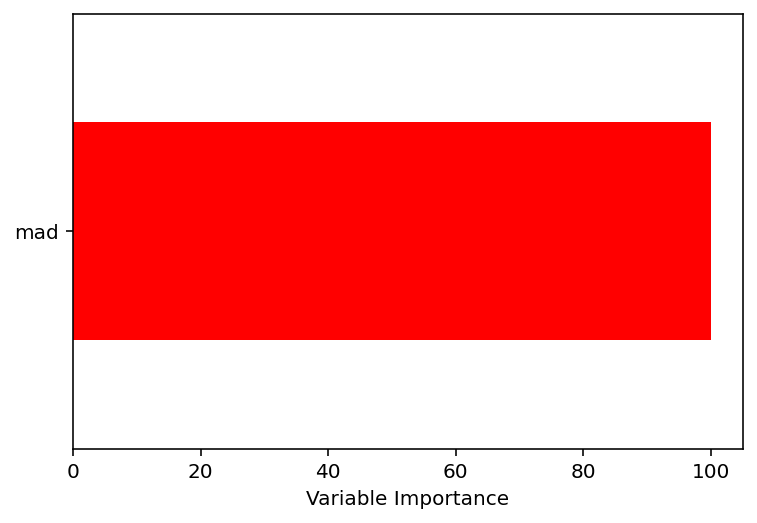

  4%|███▌                                                                               | 1/23 [00:03<01:26,  3.92s/it]

roc_auc_score 0.9042573933607558


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


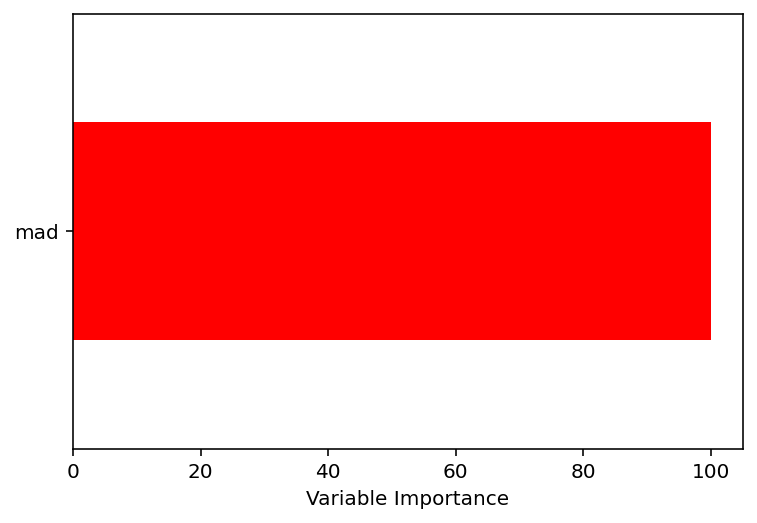

  9%|███████▏                                                                           | 2/23 [00:07<01:21,  3.89s/it]

roc_auc_score 0.9689566286217439


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


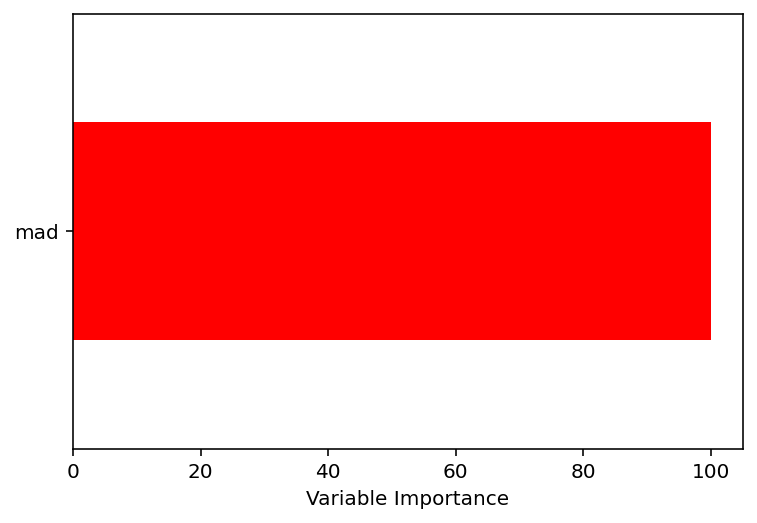

 13%|██████████▊                                                                        | 3/23 [00:11<01:18,  3.91s/it]

roc_auc_score 0.9850751290166225


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


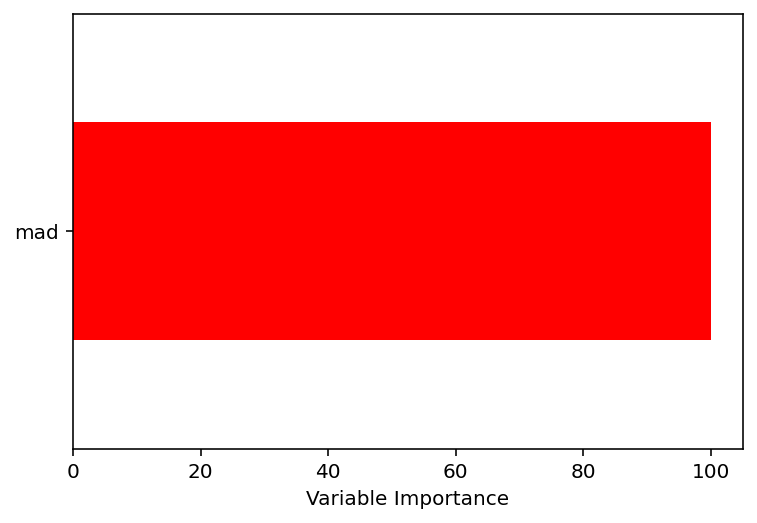

 17%|██████████████▍                                                                    | 4/23 [00:15<01:14,  3.92s/it]

roc_auc_score 0.8309821258419307


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


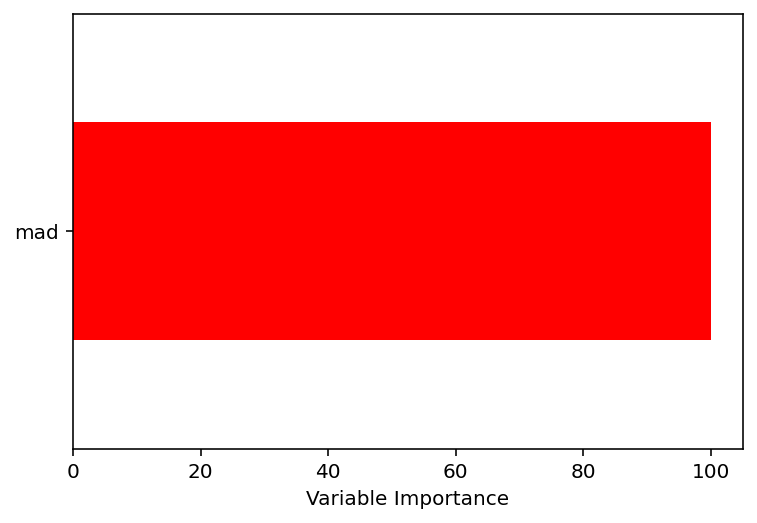

 22%|██████████████████                                                                 | 5/23 [00:19<01:10,  3.93s/it]

roc_auc_score 0.9899205021272941


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


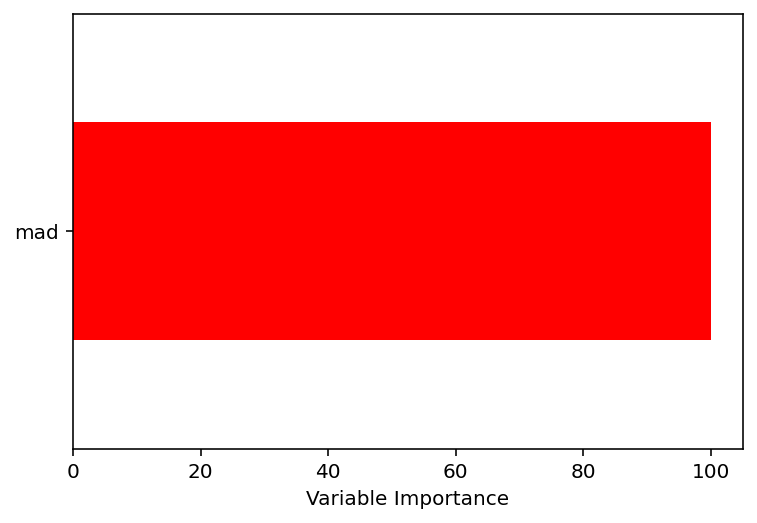

 26%|█████████████████████▋                                                             | 6/23 [00:23<01:07,  3.98s/it]

roc_auc_score 0.9567122764061002


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


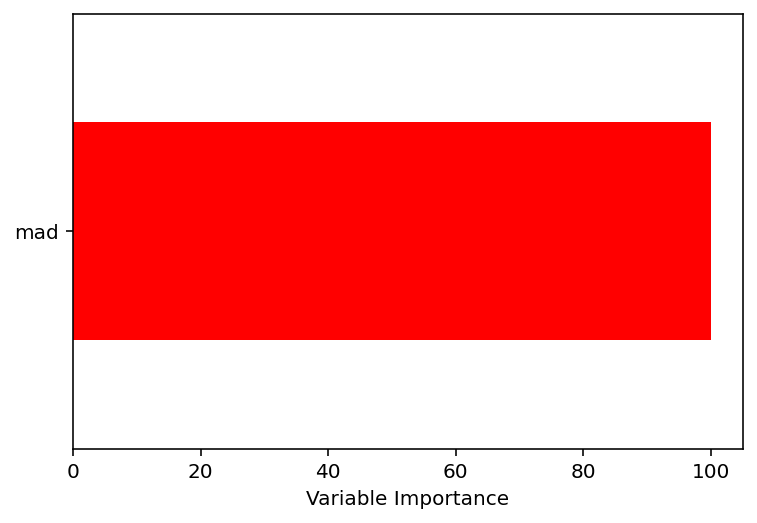

 30%|█████████████████████████▎                                                         | 7/23 [00:27<01:03,  3.95s/it]

roc_auc_score 0.9315276068710825


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


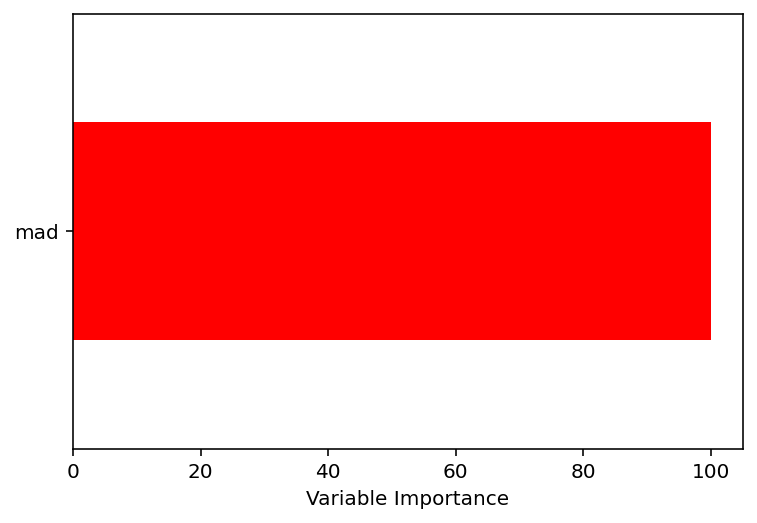

 35%|████████████████████████████▊                                                      | 8/23 [00:31<01:00,  4.00s/it]

roc_auc_score 0.9757783365957509


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


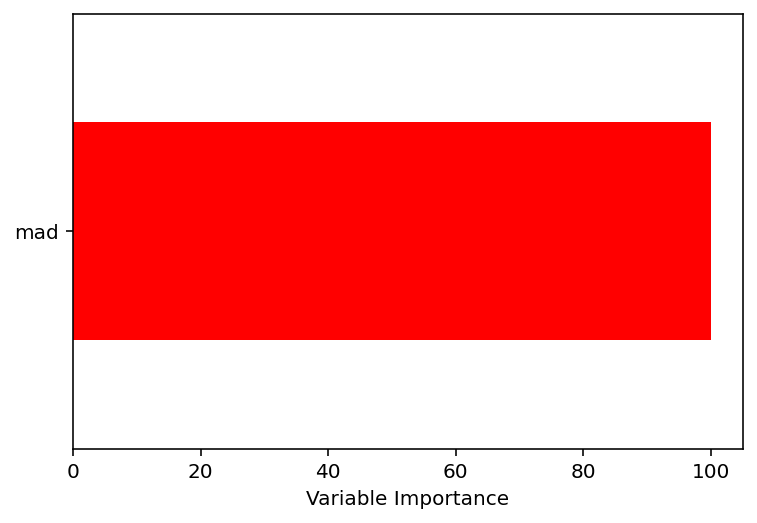

 39%|████████████████████████████████▍                                                  | 9/23 [00:35<00:57,  4.09s/it]

roc_auc_score 0.9274631057867919


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


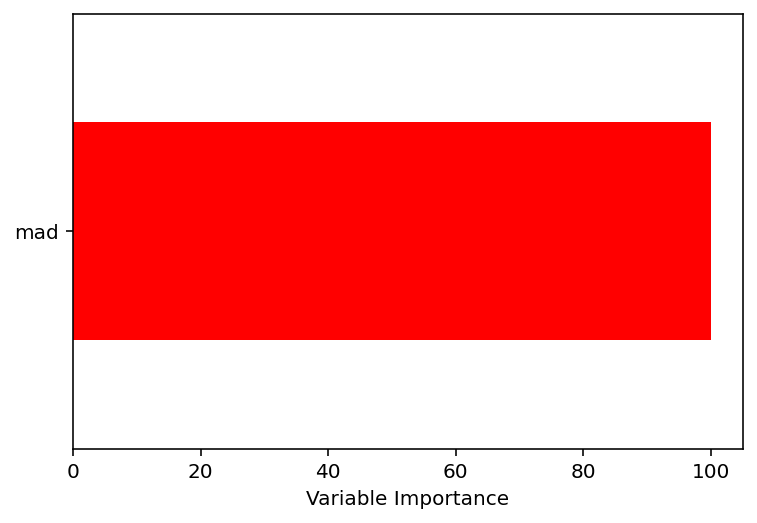

 43%|███████████████████████████████████▋                                              | 10/23 [00:40<00:55,  4.25s/it]

roc_auc_score 0.8910718984204585


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


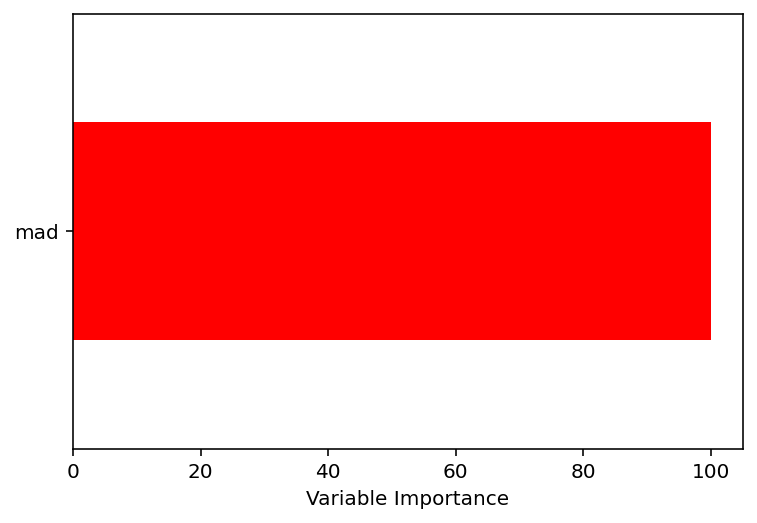

 48%|███████████████████████████████████████▏                                          | 11/23 [00:45<00:52,  4.34s/it]

roc_auc_score 0.7891465738505556


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


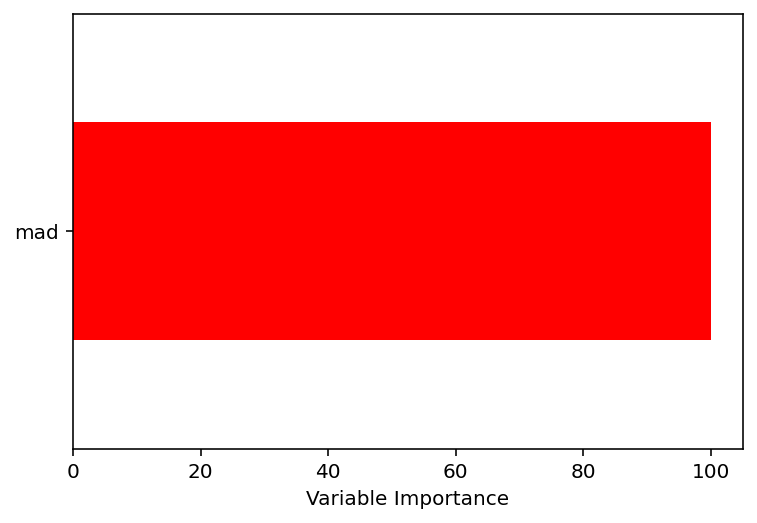

 52%|██████████████████████████████████████████▊                                       | 12/23 [00:49<00:48,  4.38s/it]

roc_auc_score 0.9560178067092123


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


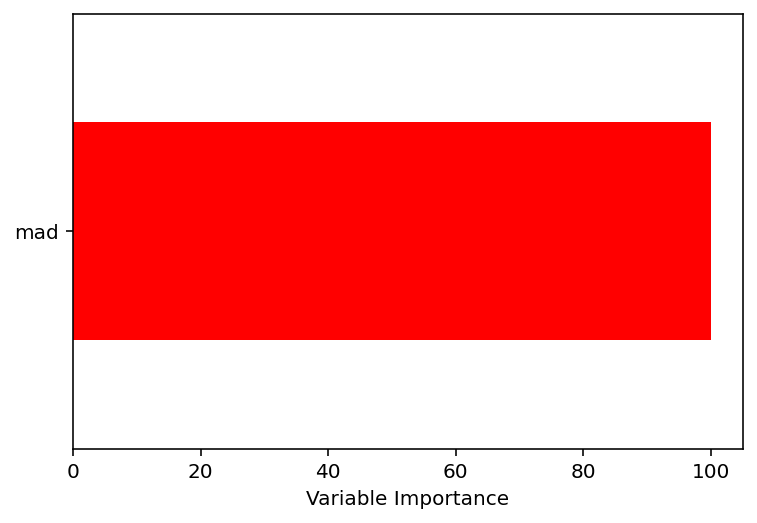

 57%|██████████████████████████████████████████████▎                                   | 13/23 [00:53<00:43,  4.32s/it]

roc_auc_score 0.889427678389193


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


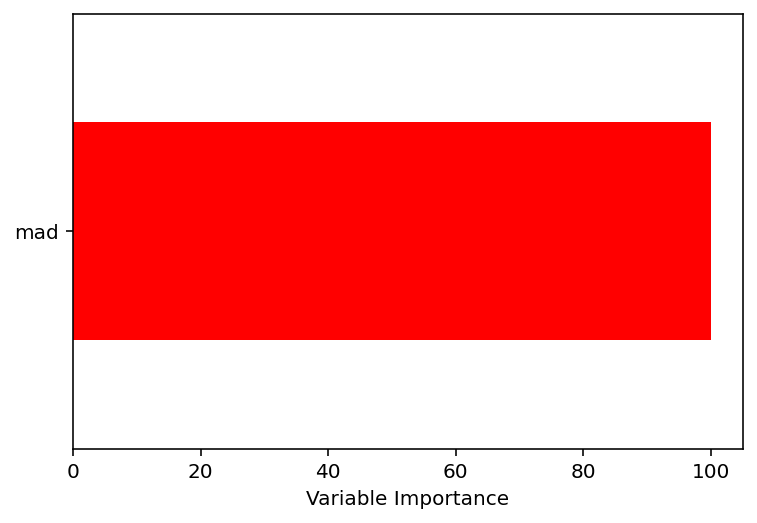

 70%|█████████████████████████████████████████████████████████                         | 16/23 [00:57<00:18,  2.66s/it]

roc_auc_score 0.9161731306168311


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


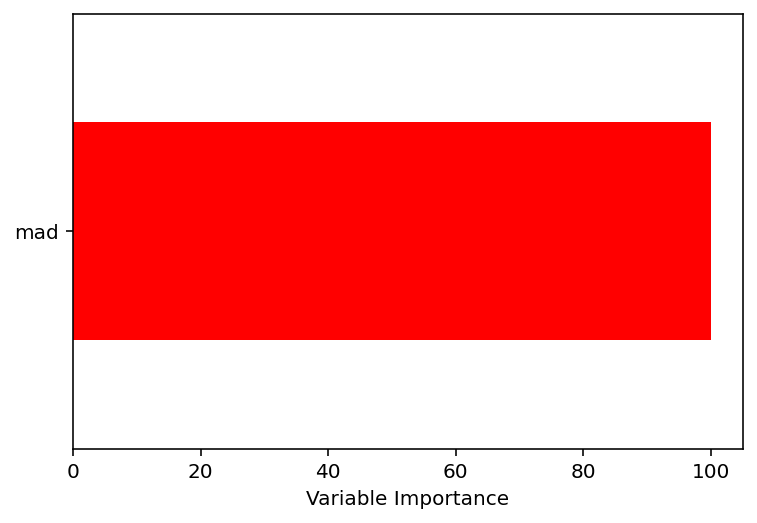

 74%|████████████████████████████████████████████████████████████▌                     | 17/23 [01:02<00:17,  3.00s/it]

roc_auc_score 0.9853243309321393


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


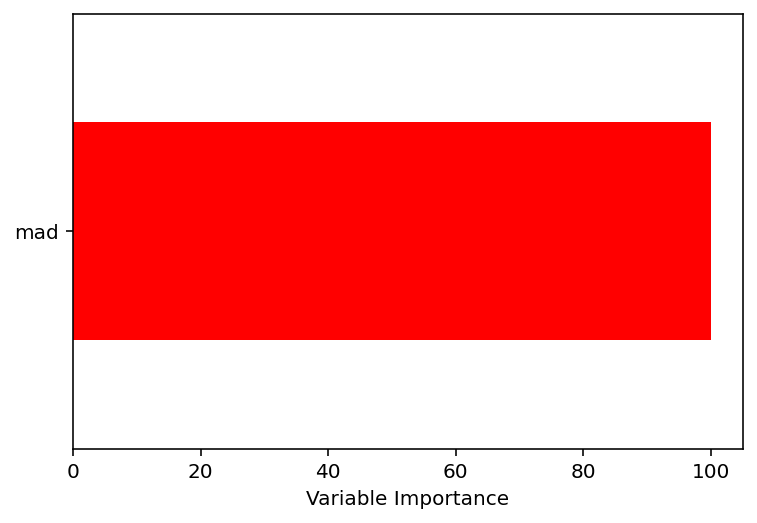

 78%|████████████████████████████████████████████████████████████████▏                 | 18/23 [01:06<00:16,  3.28s/it]

roc_auc_score 0.9983546330992409


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


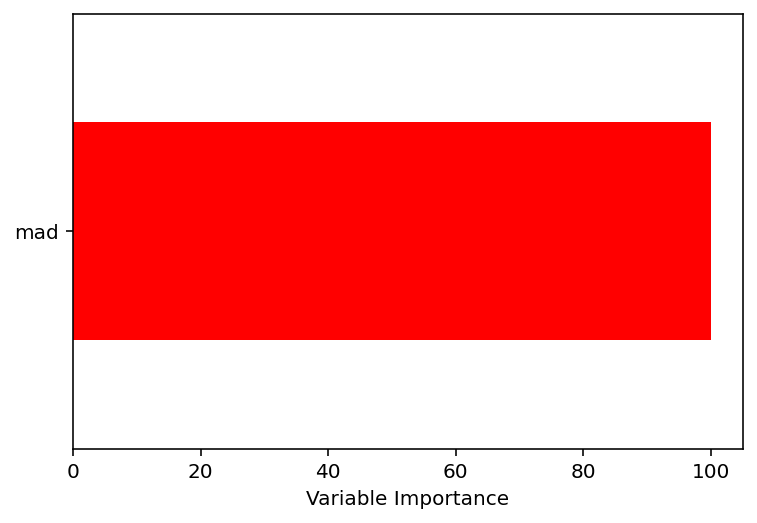

 83%|███████████████████████████████████████████████████████████████████▋              | 19/23 [01:10<00:13,  3.50s/it]

roc_auc_score 0.7247432141400898


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


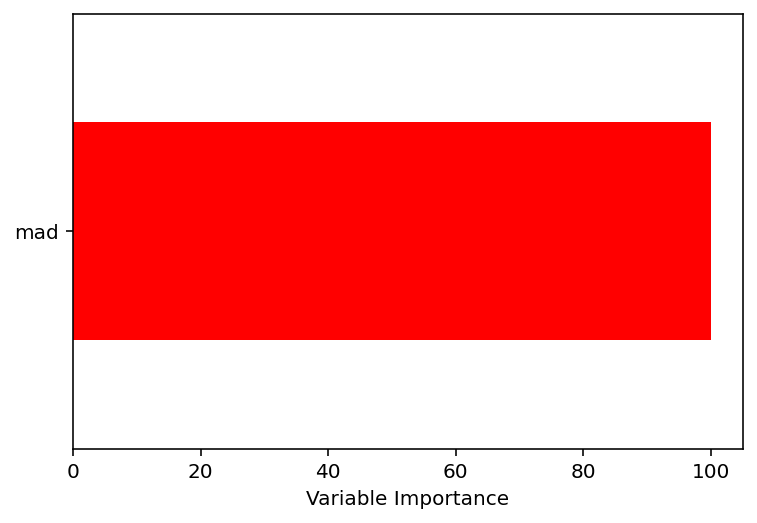

 87%|███████████████████████████████████████████████████████████████████████▎          | 20/23 [01:14<00:11,  3.70s/it]

roc_auc_score 0.9775507336604728


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


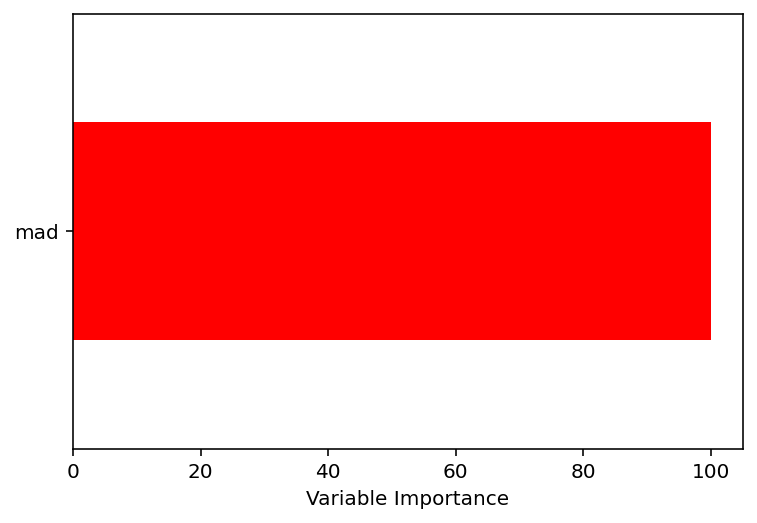

 91%|██████████████████████████████████████████████████████████████████████████▊       | 21/23 [01:18<00:07,  3.82s/it]

roc_auc_score 0.9874257993204242


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


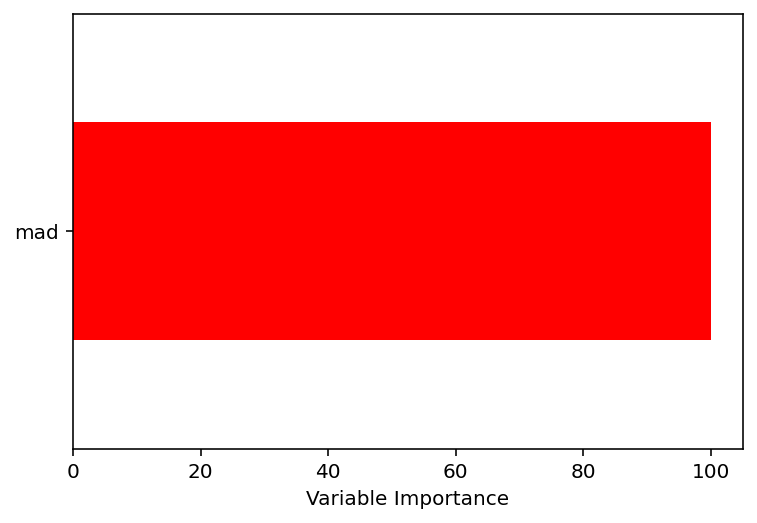

 96%|██████████████████████████████████████████████████████████████████████████████▍   | 22/23 [01:23<00:03,  3.93s/it]

roc_auc_score 0.9363496852674342


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


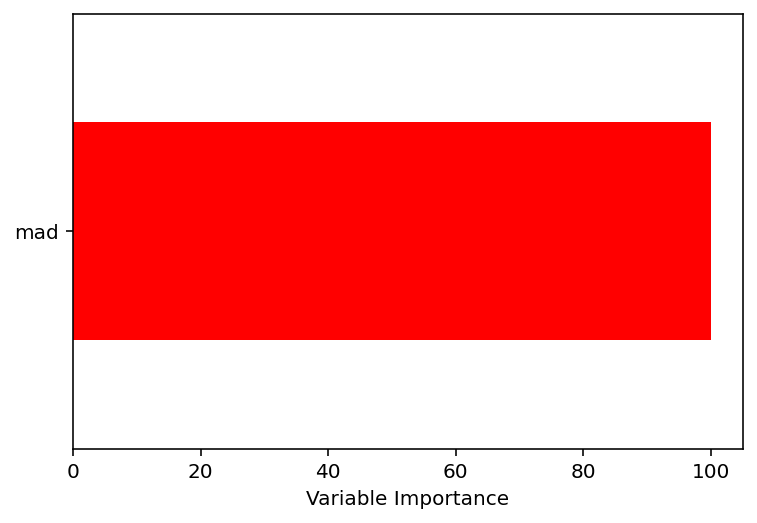

100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [01:27<00:00,  3.80s/it]

roc_auc_score 0.9946115164661802
---Run time is 87.3483034002129 seconds ---

Accuracy of each fold: 
 [0.8579630895420369, 0.9282593922920105, 0.9722473604826546, 0.5918023582257159, 0.9660846627308127, 0.9181508515815086, 0.8941941268773818, 0.942380094941889, 0.9036769138034961, 0.6755185625578015, 0.9728491985606804, 0.8645239329531709, 0.7229847494553376, 0.8094323516858728, 0.8928985267339844, 0.9851492019430951, 0.5054755627661732, 0.9427854122621564, 0.9692574813604331, 0.8899124131682271, 0.9692105794467999]

Avg accuracy : 
0.8654646106367255

Std of accuracy : 
0.13006011744790444
[[83219 19666]
 [ 3627 64494]]
classification report: 
              precision    recall  f1-score   support

           0       0.96      0.81      0.88    102885
           1       0.77      0.95      0.85     68121

    accuracy                           0.86    171006
   macro avg       0.86      0.88      0.86    171006
weighted avg       0.88      0.86      0.87    171006



In [12]:
# XGBoost
print(xgb.__version__)
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

# Create the Extreme GBM
model = XGBClassifier(n_estimators=100, learning_rate = 0.1,use_label_encoder =False,verbose=None,
                max_depth = 5, eval_metric='logloss')

start_time = timeit.default_timer() #defines start time so computational time can be calculated

acc_score = []
Truth = []
Output = []
 
for train, test in tqdm(splits):
    X_train = X.iloc[train]
    y_train = y.iloc[train]

    X_test = X.iloc[test]
    y_test = y.iloc[test]

    a = y_test.to_numpy() # s.values (pandas<0.24)
    if (a[0] == a).all():
        continue
    
    model.fit(X_train,y_train)

    pred_values = model.predict(X_test)
    pred_prob = model.predict_proba(X_test)[:, 1]
     
    acc = accuracy_score(y_test, pred_values)
    acc_score.append(acc)
    
    Truth.extend(y_test.values.reshape(y_test.shape[0])); ## it is a list
    Output.extend(pred_values); ## it is a list 
    
    #print(model.feature_importances_)
    Importance = pd.DataFrame({'Importance':(model.feature_importances_*100)[0:10]}, 
                          index = (X_train.columns)[0:10])
    Importance.sort_values(by = 'Importance', 
                       axis = 0, 
                       ascending = True).plot(kind = 'barh', 
                                              color = 'r')
    plt.xlabel('Variable Importance')
    plt.gca().legend_ = None
    plt.show()
    #plt.savefig('plot1.png')
    
    ##################################################
    #https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html
    #Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores.
    print("roc_auc_score", roc_auc_score(y_test, pred_prob))
    
    # calculate the fpr and tpr for all thresholds of the classification
    #fpr, tpr, threshold = metrics.roc_curve(y_test, pred_prob)
    #roc_auc = metrics.auc(fpr, tpr)
    # method I: plt
    #import matplotlib.pyplot as plt
    #plt.title('Receiver Operating Characteristic')
    #plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    #plt.legend(loc = 'lower right')
    #plt.plot([0, 1], [0, 1],'r--')
    #plt.xlim([-0.05, 1])
    #plt.ylim([0, 1.05])
    #plt.ylabel('True Positive Rate')
    #plt.xlabel('False Positive Rate')
    #plt.show()
    ##################################################
    
elapsed = timeit.default_timer() - start_time #gives total computation time
print("---Run time is %s seconds ---" % elapsed) #prints computation time
print()

print('Accuracy of each fold: \n {}'.format(acc_score))
print()
print('Avg accuracy : \n{}'.format(np.mean(acc_score))); 
print()
print('Std of accuracy : \n{}'.format(np.std(acc_score)))

cm = confusion_matrix(Truth, Output)
print(cm)
print("classification report: ")
print(classification_report(Truth, Output))

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

performance_dict['Avg Accuracy'].append(np.mean(acc_score))
performance_dict['Std Accuracy'].append(np.std(acc_score))
performance_dict['Sensitivity'].append(sensitivity)
performance_dict['Specificity'].append(specificity)
performance_dict['Precision'].append(precision)
performance_dict['F1 score'].append(f1_score)
performance_dict['Run time'].append(elapsed)

  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

[0]	validation_0-logloss:0.62609	validation_1-logloss:0.63359
[1]	validation_0-logloss:0.57233	validation_1-logloss:0.58491
[2]	validation_0-logloss:0.52831	validation_1-logloss:0.54454
[3]	validation_0-logloss:0.49217	validation_1-logloss:0.51072


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[4]	validation_0-logloss:0.46203	validation_1-logloss:0.48217
[5]	validation_0-logloss:0.43678	validation_1-logloss:0.45784
[6]	validation_0-logloss:0.41555	validation_1-logloss:0.43700
[7]	validation_0-logloss:0.39763	validation_1-logloss:0.41913
[8]	validation_0-logloss:0.38248	validation_1-logloss:0.40373
[9]	validation_0-logloss:0.36963	validation_1-logloss:0.39041
[10]	validation_0-logloss:0.35870	validation_1-logloss:0.37887
[11]	validation_0-logloss:0.34944	validation_1-logloss:0.36887
[12]	validation_0-logloss:0.34157	validation_1-logloss:0.36015
[13]	validation_0-logloss:0.33487	validation_1-logloss:0.35256
[14]	validation_0-logloss:0.32920	validation_1-logloss:0.34597
[15]	validation_0-logloss:0.32439	validation_1-logloss:0.34020
[16]	validation_0-logloss:0.32029	validation_1-logloss:0.33517
[17]	validation_0-logloss:0.31684	validation_1-logloss:0.33076
[18]	validation_0-logloss:0.31388	validation_1-logloss:0.32692
[19]	validation_0-logloss:0.31141	validation_1-logloss:0.3235

  4%|███▌                                                                               | 1/23 [00:04<01:39,  4.50s/it]

[0]	validation_0-logloss:0.62013	validation_1-logloss:0.63452
[1]	validation_0-logloss:0.56042	validation_1-logloss:0.58657
[2]	validation_0-logloss:0.51066	validation_1-logloss:0.54684


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[3]	validation_0-logloss:0.46882	validation_1-logloss:0.51354
[4]	validation_0-logloss:0.43324	validation_1-logloss:0.48541
[5]	validation_0-logloss:0.40278	validation_1-logloss:0.46146
[6]	validation_0-logloss:0.37656	validation_1-logloss:0.44102
[7]	validation_0-logloss:0.35388	validation_1-logloss:0.42340
[8]	validation_0-logloss:0.33420	validation_1-logloss:0.40825
[9]	validation_0-logloss:0.31703	validation_1-logloss:0.39517
[10]	validation_0-logloss:0.30201	validation_1-logloss:0.38381
[11]	validation_0-logloss:0.28887	validation_1-logloss:0.37395
[12]	validation_0-logloss:0.27731	validation_1-logloss:0.36539
[13]	validation_0-logloss:0.26714	validation_1-logloss:0.35794
[14]	validation_0-logloss:0.25822	validation_1-logloss:0.35144
[15]	validation_0-logloss:0.25035	validation_1-logloss:0.34577
[16]	validation_0-logloss:0.24342	validation_1-logloss:0.34081
[17]	validation_0-logloss:0.23731	validation_1-logloss:0.33648
[18]	validation_0-logloss:0.23188	validation_1-logloss:0.33269

  9%|███████▏                                                                           | 2/23 [00:08<01:32,  4.42s/it]

[0]	validation_0-logloss:0.60588	validation_1-logloss:0.63476
[1]	validation_0-logloss:0.53464	validation_1-logloss:0.58701
[2]	validation_0-logloss:0.47519	validation_1-logloss:0.54751


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[3]	validation_0-logloss:0.42465	validation_1-logloss:0.51432
[4]	validation_0-logloss:0.38154	validation_1-logloss:0.48633
[5]	validation_0-logloss:0.34457	validation_1-logloss:0.46252
[6]	validation_0-logloss:0.31253	validation_1-logloss:0.44216
[7]	validation_0-logloss:0.28462	validation_1-logloss:0.42468
[8]	validation_0-logloss:0.26017	validation_1-logloss:0.40962
[9]	validation_0-logloss:0.23870	validation_1-logloss:0.39661
[10]	validation_0-logloss:0.21980	validation_1-logloss:0.38532
[11]	validation_0-logloss:0.20305	validation_1-logloss:0.37555
[12]	validation_0-logloss:0.18824	validation_1-logloss:0.36708
[13]	validation_0-logloss:0.17502	validation_1-logloss:0.35968
[14]	validation_0-logloss:0.16327	validation_1-logloss:0.35322
[15]	validation_0-logloss:0.15280	validation_1-logloss:0.34761
[16]	validation_0-logloss:0.14345	validation_1-logloss:0.34271
[17]	validation_0-logloss:0.13509	validation_1-logloss:0.33842
[18]	validation_0-logloss:0.12762	validation_1-logloss:0.33466

 13%|██████████▊                                                                        | 3/23 [00:13<01:28,  4.43s/it]

[0]	validation_0-logloss:0.67226	validation_1-logloss:0.63167
[1]	validation_0-logloss:0.65696	validation_1-logloss:0.58136
[2]	validation_0-logloss:0.64579	validation_1-logloss:0.53970


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[3]	validation_0-logloss:0.63785	validation_1-logloss:0.50476
[4]	validation_0-logloss:0.63232	validation_1-logloss:0.47519
[5]	validation_0-logloss:0.62874	validation_1-logloss:0.45002
[6]	validation_0-logloss:0.62661	validation_1-logloss:0.42851
[7]	validation_0-logloss:0.62563	validation_1-logloss:0.41002
[8]	validation_0-logloss:0.62548	validation_1-logloss:0.39407
[9]	validation_0-logloss:0.62609	validation_1-logloss:0.38027
[10]	validation_0-logloss:0.62733	validation_1-logloss:0.36832
[11]	validation_0-logloss:0.62887	validation_1-logloss:0.35794
[12]	validation_0-logloss:0.63074	validation_1-logloss:0.34890
[13]	validation_0-logloss:0.63281	validation_1-logloss:0.34105
[14]	validation_0-logloss:0.63501	validation_1-logloss:0.33419
[15]	validation_0-logloss:0.63729	validation_1-logloss:0.32819
[16]	validation_0-logloss:0.63958	validation_1-logloss:0.32295
[17]	validation_0-logloss:0.64194	validation_1-logloss:0.31836
[18]	validation_0-logloss:0.64419	validation_1-logloss:0.31435

 17%|██████████████▍                                                                    | 4/23 [00:17<01:24,  4.45s/it]

[0]	validation_0-logloss:0.62212	validation_1-logloss:0.63471
[1]	validation_0-logloss:0.56331	validation_1-logloss:0.58693
[2]	validation_0-logloss:0.51361	validation_1-logloss:0.54732


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[3]	validation_0-logloss:0.47132	validation_1-logloss:0.51408
[4]	validation_0-logloss:0.43508	validation_1-logloss:0.48601
[5]	validation_0-logloss:0.40370	validation_1-logloss:0.46211
[6]	validation_0-logloss:0.37637	validation_1-logloss:0.44169
[7]	validation_0-logloss:0.35250	validation_1-logloss:0.42413
[8]	validation_0-logloss:0.33158	validation_1-logloss:0.40896
[9]	validation_0-logloss:0.31311	validation_1-logloss:0.39588
[10]	validation_0-logloss:0.29681	validation_1-logloss:0.38453
[11]	validation_0-logloss:0.28241	validation_1-logloss:0.37467
[12]	validation_0-logloss:0.26965	validation_1-logloss:0.36609
[13]	validation_0-logloss:0.25833	validation_1-logloss:0.35860
[14]	validation_0-logloss:0.24823	validation_1-logloss:0.35208
[15]	validation_0-logloss:0.23930	validation_1-logloss:0.34638
[16]	validation_0-logloss:0.23128	validation_1-logloss:0.34139
[17]	validation_0-logloss:0.22415	validation_1-logloss:0.33703
[18]	validation_0-logloss:0.21780	validation_1-logloss:0.33320

 22%|██████████████████                                                                 | 5/23 [00:22<01:19,  4.43s/it]

[0]	validation_0-logloss:0.61717	validation_1-logloss:0.63454
[1]	validation_0-logloss:0.55525	validation_1-logloss:0.58669
[2]	validation_0-logloss:0.50378	validation_1-logloss:0.54697


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[3]	validation_0-logloss:0.46055	validation_1-logloss:0.51370
[4]	validation_0-logloss:0.42358	validation_1-logloss:0.48560
[5]	validation_0-logloss:0.39223	validation_1-logloss:0.46169
[6]	validation_0-logloss:0.36523	validation_1-logloss:0.44129
[7]	validation_0-logloss:0.34182	validation_1-logloss:0.42376
[8]	validation_0-logloss:0.32154	validation_1-logloss:0.40865
[9]	validation_0-logloss:0.30385	validation_1-logloss:0.39560
[10]	validation_0-logloss:0.28835	validation_1-logloss:0.38429
[11]	validation_0-logloss:0.27477	validation_1-logloss:0.37450
[12]	validation_0-logloss:0.26282	validation_1-logloss:0.36600
[13]	validation_0-logloss:0.25229	validation_1-logloss:0.35860
[14]	validation_0-logloss:0.24290	validation_1-logloss:0.35216
[15]	validation_0-logloss:0.23460	validation_1-logloss:0.34653
[16]	validation_0-logloss:0.22724	validation_1-logloss:0.34163
[17]	validation_0-logloss:0.22071	validation_1-logloss:0.33735
[18]	validation_0-logloss:0.21491	validation_1-logloss:0.33362

 26%|█████████████████████▋                                                             | 6/23 [00:26<01:14,  4.41s/it]

[0]	validation_0-logloss:0.63549	validation_1-logloss:0.63363
[1]	validation_0-logloss:0.58851	validation_1-logloss:0.58489
[2]	validation_0-logloss:0.54986	validation_1-logloss:0.54448


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[3]	validation_0-logloss:0.51775	validation_1-logloss:0.51064
[4]	validation_0-logloss:0.49106	validation_1-logloss:0.48196
[5]	validation_0-logloss:0.46860	validation_1-logloss:0.45749
[6]	validation_0-logloss:0.44977	validation_1-logloss:0.43659
[7]	validation_0-logloss:0.43402	validation_1-logloss:0.41859
[8]	validation_0-logloss:0.42087	validation_1-logloss:0.40300
[9]	validation_0-logloss:0.40989	validation_1-logloss:0.38953
[10]	validation_0-logloss:0.40079	validation_1-logloss:0.37780
[11]	validation_0-logloss:0.39335	validation_1-logloss:0.36758
[12]	validation_0-logloss:0.38730	validation_1-logloss:0.35868
[13]	validation_0-logloss:0.38249	validation_1-logloss:0.35091
[14]	validation_0-logloss:0.37872	validation_1-logloss:0.34407
[15]	validation_0-logloss:0.37583	validation_1-logloss:0.33809
[16]	validation_0-logloss:0.37380	validation_1-logloss:0.33284
[17]	validation_0-logloss:0.37248	validation_1-logloss:0.32822
[18]	validation_0-logloss:0.37175	validation_1-logloss:0.32413

 30%|█████████████████████████▎                                                         | 7/23 [00:30<01:10,  4.38s/it]

[0]	validation_0-logloss:0.61515	validation_1-logloss:0.63442
[1]	validation_0-logloss:0.55106	validation_1-logloss:0.58637
[2]	validation_0-logloss:0.49769	validation_1-logloss:0.54653


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[3]	validation_0-logloss:0.45259	validation_1-logloss:0.51317
[4]	validation_0-logloss:0.41437	validation_1-logloss:0.48500
[5]	validation_0-logloss:0.38151	validation_1-logloss:0.46101
[6]	validation_0-logloss:0.35310	validation_1-logloss:0.44050
[7]	validation_0-logloss:0.32841	validation_1-logloss:0.42289
[8]	validation_0-logloss:0.30688	validation_1-logloss:0.40773
[9]	validation_0-logloss:0.28790	validation_1-logloss:0.39463
[10]	validation_0-logloss:0.27133	validation_1-logloss:0.38326
[11]	validation_0-logloss:0.25674	validation_1-logloss:0.37339
[12]	validation_0-logloss:0.24394	validation_1-logloss:0.36481
[13]	validation_0-logloss:0.23256	validation_1-logloss:0.35735
[14]	validation_0-logloss:0.22250	validation_1-logloss:0.35085
[15]	validation_0-logloss:0.21355	validation_1-logloss:0.34517
[16]	validation_0-logloss:0.20568	validation_1-logloss:0.34019
[17]	validation_0-logloss:0.19857	validation_1-logloss:0.33586
[18]	validation_0-logloss:0.19227	validation_1-logloss:0.33207

 35%|████████████████████████████▊                                                      | 8/23 [00:35<01:06,  4.42s/it]

[0]	validation_0-logloss:0.63625	validation_1-logloss:0.63392
[1]	validation_0-logloss:0.58931	validation_1-logloss:0.58559
[2]	validation_0-logloss:0.54967	validation_1-logloss:0.54545


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[3]	validation_0-logloss:0.51613	validation_1-logloss:0.51178
[4]	validation_0-logloss:0.48758	validation_1-logloss:0.48335
[5]	validation_0-logloss:0.46301	validation_1-logloss:0.45910
[6]	validation_0-logloss:0.44183	validation_1-logloss:0.43835
[7]	validation_0-logloss:0.42342	validation_1-logloss:0.42057
[8]	validation_0-logloss:0.40738	validation_1-logloss:0.40521
[9]	validation_0-logloss:0.39338	validation_1-logloss:0.39190
[10]	validation_0-logloss:0.38110	validation_1-logloss:0.38038
[11]	validation_0-logloss:0.37035	validation_1-logloss:0.37034
[12]	validation_0-logloss:0.36093	validation_1-logloss:0.36162
[13]	validation_0-logloss:0.35267	validation_1-logloss:0.35401
[14]	validation_0-logloss:0.34533	validation_1-logloss:0.34738
[15]	validation_0-logloss:0.33887	validation_1-logloss:0.34155
[16]	validation_0-logloss:0.33324	validation_1-logloss:0.33649
[17]	validation_0-logloss:0.32817	validation_1-logloss:0.33207
[18]	validation_0-logloss:0.32379	validation_1-logloss:0.32817

 39%|████████████████████████████████▍                                                  | 9/23 [00:39<01:01,  4.42s/it]

[0]	validation_0-logloss:0.65466	validation_1-logloss:0.63175
[1]	validation_0-logloss:0.62584	validation_1-logloss:0.58162
[2]	validation_0-logloss:0.60400	validation_1-logloss:0.54001


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[3]	validation_0-logloss:0.58779	validation_1-logloss:0.50511
[4]	validation_0-logloss:0.57576	validation_1-logloss:0.47560
[5]	validation_0-logloss:0.56700	validation_1-logloss:0.45051
[6]	validation_0-logloss:0.56081	validation_1-logloss:0.42902
[7]	validation_0-logloss:0.55676	validation_1-logloss:0.41055
[8]	validation_0-logloss:0.55436	validation_1-logloss:0.39464
[9]	validation_0-logloss:0.55326	validation_1-logloss:0.38084
[10]	validation_0-logloss:0.55329	validation_1-logloss:0.36891
[11]	validation_0-logloss:0.55411	validation_1-logloss:0.35854
[12]	validation_0-logloss:0.55563	validation_1-logloss:0.34952
[13]	validation_0-logloss:0.55768	validation_1-logloss:0.34165
[14]	validation_0-logloss:0.56014	validation_1-logloss:0.33479
[15]	validation_0-logloss:0.56285	validation_1-logloss:0.32883
[16]	validation_0-logloss:0.56578	validation_1-logloss:0.32360
[17]	validation_0-logloss:0.56883	validation_1-logloss:0.31903
[18]	validation_0-logloss:0.57194	validation_1-logloss:0.31503

 43%|███████████████████████████████████▋                                              | 10/23 [00:44<00:57,  4.42s/it]

[0]	validation_0-logloss:0.62816	validation_1-logloss:0.63475
[1]	validation_0-logloss:0.57361	validation_1-logloss:0.58702
[2]	validation_0-logloss:0.52736	validation_1-logloss:0.54746


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[3]	validation_0-logloss:0.48794	validation_1-logloss:0.51429
[4]	validation_0-logloss:0.45385	validation_1-logloss:0.48625
[5]	validation_0-logloss:0.42437	validation_1-logloss:0.46237
[6]	validation_0-logloss:0.39886	validation_1-logloss:0.44192
[7]	validation_0-logloss:0.37640	validation_1-logloss:0.42435
[8]	validation_0-logloss:0.35667	validation_1-logloss:0.40918
[9]	validation_0-logloss:0.33934	validation_1-logloss:0.39605
[10]	validation_0-logloss:0.32408	validation_1-logloss:0.38467
[11]	validation_0-logloss:0.31057	validation_1-logloss:0.37478
[12]	validation_0-logloss:0.29862	validation_1-logloss:0.36613
[13]	validation_0-logloss:0.28817	validation_1-logloss:0.35863
[14]	validation_0-logloss:0.27876	validation_1-logloss:0.35205
[15]	validation_0-logloss:0.27045	validation_1-logloss:0.34632
[16]	validation_0-logloss:0.26298	validation_1-logloss:0.34128
[17]	validation_0-logloss:0.25636	validation_1-logloss:0.33687
[18]	validation_0-logloss:0.25062	validation_1-logloss:0.33302

 48%|███████████████████████████████████████▏                                          | 11/23 [00:48<00:52,  4.41s/it]

[0]	validation_0-logloss:0.62449	validation_1-logloss:0.63387
[1]	validation_0-logloss:0.56906	validation_1-logloss:0.58536
[2]	validation_0-logloss:0.52333	validation_1-logloss:0.54517


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[3]	validation_0-logloss:0.48512	validation_1-logloss:0.51150
[4]	validation_0-logloss:0.45294	validation_1-logloss:0.48301
[5]	validation_0-logloss:0.42574	validation_1-logloss:0.45879
[6]	validation_0-logloss:0.40247	validation_1-logloss:0.43808
[7]	validation_0-logloss:0.38248	validation_1-logloss:0.42029
[8]	validation_0-logloss:0.36526	validation_1-logloss:0.40497
[9]	validation_0-logloss:0.35029	validation_1-logloss:0.39170
[10]	validation_0-logloss:0.33732	validation_1-logloss:0.38024
[11]	validation_0-logloss:0.32604	validation_1-logloss:0.37029
[12]	validation_0-logloss:0.31625	validation_1-logloss:0.36163
[13]	validation_0-logloss:0.30764	validation_1-logloss:0.35409
[14]	validation_0-logloss:0.30008	validation_1-logloss:0.34752
[15]	validation_0-logloss:0.29348	validation_1-logloss:0.34178
[16]	validation_0-logloss:0.28762	validation_1-logloss:0.33676
[17]	validation_0-logloss:0.28245	validation_1-logloss:0.33241
[18]	validation_0-logloss:0.27791	validation_1-logloss:0.32856

 52%|██████████████████████████████████████████▊                                       | 12/23 [00:53<00:48,  4.42s/it]

[0]	validation_0-logloss:0.65938	validation_1-logloss:0.63229
[1]	validation_0-logloss:0.63220	validation_1-logloss:0.58256
[2]	validation_0-logloss:0.61025	validation_1-logloss:0.54124
[3]	validation_0-logloss:0.59231	validation_1-logloss:0.50667


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[4]	validation_0-logloss:0.57740	validation_1-logloss:0.47738
[5]	validation_0-logloss:0.56498	validation_1-logloss:0.45251
[6]	validation_0-logloss:0.55488	validation_1-logloss:0.43119
[7]	validation_0-logloss:0.54658	validation_1-logloss:0.41286
[8]	validation_0-logloss:0.53972	validation_1-logloss:0.39707
[9]	validation_0-logloss:0.53395	validation_1-logloss:0.38338
[10]	validation_0-logloss:0.52915	validation_1-logloss:0.37153
[11]	validation_0-logloss:0.52526	validation_1-logloss:0.36123
[12]	validation_0-logloss:0.52202	validation_1-logloss:0.35225
[13]	validation_0-logloss:0.51939	validation_1-logloss:0.34442
[14]	validation_0-logloss:0.51723	validation_1-logloss:0.33758
[15]	validation_0-logloss:0.51544	validation_1-logloss:0.33161
[16]	validation_0-logloss:0.51402	validation_1-logloss:0.32640
[17]	validation_0-logloss:0.51281	validation_1-logloss:0.32183
[18]	validation_0-logloss:0.51191	validation_1-logloss:0.31782
[19]	validation_0-logloss:0.51119	validation_1-logloss:0.3143

 57%|██████████████████████████████████████████████▎                                   | 13/23 [00:57<00:44,  4.41s/it]

[0]	validation_0-logloss:0.63956	validation_1-logloss:0.63448
[1]	validation_0-logloss:0.59507	validation_1-logloss:0.58653
[2]	validation_0-logloss:0.55754	validation_1-logloss:0.54675


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[3]	validation_0-logloss:0.52541	validation_1-logloss:0.51338
[4]	validation_0-logloss:0.49814	validation_1-logloss:0.48520
[5]	validation_0-logloss:0.47470	validation_1-logloss:0.46119
[6]	validation_0-logloss:0.45408	validation_1-logloss:0.44064
[7]	validation_0-logloss:0.43632	validation_1-logloss:0.42297
[8]	validation_0-logloss:0.42089	validation_1-logloss:0.40774
[9]	validation_0-logloss:0.40719	validation_1-logloss:0.39458
[10]	validation_0-logloss:0.39542	validation_1-logloss:0.38314
[11]	validation_0-logloss:0.38489	validation_1-logloss:0.37321
[12]	validation_0-logloss:0.37579	validation_1-logloss:0.36457
[13]	validation_0-logloss:0.36754	validation_1-logloss:0.35704
[14]	validation_0-logloss:0.35968	validation_1-logloss:0.35045
[15]	validation_0-logloss:0.35363	validation_1-logloss:0.34469
[16]	validation_0-logloss:0.34829	validation_1-logloss:0.33964
[17]	validation_0-logloss:0.34345	validation_1-logloss:0.33524
[18]	validation_0-logloss:0.33931	validation_1-logloss:0.33136

 61%|█████████████████████████████████████████████████▉                                | 14/23 [01:01<00:39,  4.42s/it]

[0]	validation_0-logloss:0.68938	validation_1-logloss:0.63130
[1]	validation_0-logloss:0.68715	validation_1-logloss:0.58080
[2]	validation_0-logloss:0.68596	validation_1-logloss:0.53887


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[3]	validation_0-logloss:0.68565	validation_1-logloss:0.50373
[4]	validation_0-logloss:0.68596	validation_1-logloss:0.47396
[5]	validation_0-logloss:0.68672	validation_1-logloss:0.44864
[6]	validation_0-logloss:0.68774	validation_1-logloss:0.42698
[7]	validation_0-logloss:0.68895	validation_1-logloss:0.40832
[8]	validation_0-logloss:0.69040	validation_1-logloss:0.39226
[9]	validation_0-logloss:0.69196	validation_1-logloss:0.37831
[10]	validation_0-logloss:0.69367	validation_1-logloss:0.36623
[11]	validation_0-logloss:0.69536	validation_1-logloss:0.35575
[12]	validation_0-logloss:0.69715	validation_1-logloss:0.34661
[13]	validation_0-logloss:0.69873	validation_1-logloss:0.33864
[14]	validation_0-logloss:0.70018	validation_1-logloss:0.33167
[15]	validation_0-logloss:0.70178	validation_1-logloss:0.32560
[16]	validation_0-logloss:0.70326	validation_1-logloss:0.32028
[17]	validation_0-logloss:0.70472	validation_1-logloss:0.31563
[18]	validation_0-logloss:0.70602	validation_1-logloss:0.31154

 65%|█████████████████████████████████████████████████████▍                            | 15/23 [01:06<00:35,  4.39s/it]

[0]	validation_0-logloss:0.64882	validation_1-logloss:0.63287
[1]	validation_0-logloss:0.61292	validation_1-logloss:0.58361
[2]	validation_0-logloss:0.58368	validation_1-logloss:0.54271


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[3]	validation_0-logloss:0.55956	validation_1-logloss:0.50840
[4]	validation_0-logloss:0.53951	validation_1-logloss:0.47943
[5]	validation_0-logloss:0.52275	validation_1-logloss:0.45476
[6]	validation_0-logloss:0.50877	validation_1-logloss:0.43362
[7]	validation_0-logloss:0.49710	validation_1-logloss:0.41545
[8]	validation_0-logloss:0.48733	validation_1-logloss:0.39978
[9]	validation_0-logloss:0.47921	validation_1-logloss:0.38619
[10]	validation_0-logloss:0.47240	validation_1-logloss:0.37443
[11]	validation_0-logloss:0.46668	validation_1-logloss:0.36422
[12]	validation_0-logloss:0.46195	validation_1-logloss:0.35531
[13]	validation_0-logloss:0.45807	validation_1-logloss:0.34754
[14]	validation_0-logloss:0.45490	validation_1-logloss:0.34075
[15]	validation_0-logloss:0.45230	validation_1-logloss:0.33483
[16]	validation_0-logloss:0.45022	validation_1-logloss:0.32966
[17]	validation_0-logloss:0.44855	validation_1-logloss:0.32510
[18]	validation_0-logloss:0.44726	validation_1-logloss:0.32113

 70%|█████████████████████████████████████████████████████████                         | 16/23 [01:10<00:30,  4.39s/it]

[0]	validation_0-logloss:0.62089	validation_1-logloss:0.63406
[1]	validation_0-logloss:0.56195	validation_1-logloss:0.58573
[2]	validation_0-logloss:0.51317	validation_1-logloss:0.54570


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[3]	validation_0-logloss:0.47222	validation_1-logloss:0.51215
[4]	validation_0-logloss:0.43762	validation_1-logloss:0.48378
[5]	validation_0-logloss:0.40807	validation_1-logloss:0.45966
[6]	validation_0-logloss:0.38272	validation_1-logloss:0.43905
[7]	validation_0-logloss:0.36084	validation_1-logloss:0.42132
[8]	validation_0-logloss:0.34185	validation_1-logloss:0.40605
[9]	validation_0-logloss:0.32537	validation_1-logloss:0.39285
[10]	validation_0-logloss:0.31100	validation_1-logloss:0.38140
[11]	validation_0-logloss:0.29840	validation_1-logloss:0.37147
[12]	validation_0-logloss:0.28735	validation_1-logloss:0.36287
[13]	validation_0-logloss:0.27764	validation_1-logloss:0.35536
[14]	validation_0-logloss:0.26909	validation_1-logloss:0.34880
[15]	validation_0-logloss:0.26154	validation_1-logloss:0.34308
[16]	validation_0-logloss:0.25486	validation_1-logloss:0.33809
[17]	validation_0-logloss:0.24900	validation_1-logloss:0.33373
[18]	validation_0-logloss:0.24379	validation_1-logloss:0.32991

 74%|████████████████████████████████████████████████████████████▌                     | 17/23 [01:15<00:26,  4.41s/it]

[0]	validation_0-logloss:0.61831	validation_1-logloss:0.63487
[1]	validation_0-logloss:0.55568	validation_1-logloss:0.58723
[2]	validation_0-logloss:0.50267	validation_1-logloss:0.54768


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[3]	validation_0-logloss:0.45748	validation_1-logloss:0.51452
[4]	validation_0-logloss:0.41906	validation_1-logloss:0.48656
[5]	validation_0-logloss:0.38535	validation_1-logloss:0.46271
[6]	validation_0-logloss:0.35591	validation_1-logloss:0.44235
[7]	validation_0-logloss:0.33015	validation_1-logloss:0.42484
[8]	validation_0-logloss:0.30751	validation_1-logloss:0.40974
[9]	validation_0-logloss:0.28751	validation_1-logloss:0.39668
[10]	validation_0-logloss:0.26984	validation_1-logloss:0.38537
[11]	validation_0-logloss:0.25420	validation_1-logloss:0.37553
[12]	validation_0-logloss:0.24027	validation_1-logloss:0.36698
[13]	validation_0-logloss:0.22785	validation_1-logloss:0.35954
[14]	validation_0-logloss:0.21685	validation_1-logloss:0.35304
[15]	validation_0-logloss:0.20707	validation_1-logloss:0.34736
[16]	validation_0-logloss:0.19824	validation_1-logloss:0.34238
[17]	validation_0-logloss:0.19027	validation_1-logloss:0.33801
[18]	validation_0-logloss:0.18320	validation_1-logloss:0.33420

 78%|████████████████████████████████████████████████████████████████▏                 | 18/23 [01:19<00:22,  4.43s/it]

[0]	validation_0-logloss:0.68746	validation_1-logloss:0.62915
[1]	validation_0-logloss:0.68636	validation_1-logloss:0.57680
[2]	validation_0-logloss:0.68851	validation_1-logloss:0.53334


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[3]	validation_0-logloss:0.69299	validation_1-logloss:0.49687
[4]	validation_0-logloss:0.69927	validation_1-logloss:0.46608
[5]	validation_0-logloss:0.70676	validation_1-logloss:0.43985
[6]	validation_0-logloss:0.71514	validation_1-logloss:0.41736
[7]	validation_0-logloss:0.72415	validation_1-logloss:0.39805
[8]	validation_0-logloss:0.73348	validation_1-logloss:0.38138
[9]	validation_0-logloss:0.74296	validation_1-logloss:0.36695
[10]	validation_0-logloss:0.75252	validation_1-logloss:0.35444
[11]	validation_0-logloss:0.76200	validation_1-logloss:0.34355
[12]	validation_0-logloss:0.77140	validation_1-logloss:0.33409
[13]	validation_0-logloss:0.78058	validation_1-logloss:0.32585
[14]	validation_0-logloss:0.78947	validation_1-logloss:0.31866
[15]	validation_0-logloss:0.79798	validation_1-logloss:0.31237
[16]	validation_0-logloss:0.80617	validation_1-logloss:0.30689
[17]	validation_0-logloss:0.81396	validation_1-logloss:0.30208
[18]	validation_0-logloss:0.82135	validation_1-logloss:0.29788

 83%|███████████████████████████████████████████████████████████████████▋              | 19/23 [01:23<00:17,  4.41s/it]

[0]	validation_0-logloss:0.61679	validation_1-logloss:0.63451
[1]	validation_0-logloss:0.55403	validation_1-logloss:0.58658
[2]	validation_0-logloss:0.50183	validation_1-logloss:0.54676


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[3]	validation_0-logloss:0.45769	validation_1-logloss:0.51346
[4]	validation_0-logloss:0.42011	validation_1-logloss:0.48530
[5]	validation_0-logloss:0.38777	validation_1-logloss:0.46136
[6]	validation_0-logloss:0.35986	validation_1-logloss:0.44088
[7]	validation_0-logloss:0.33530	validation_1-logloss:0.42327
[8]	validation_0-logloss:0.31396	validation_1-logloss:0.40813
[9]	validation_0-logloss:0.29523	validation_1-logloss:0.39503
[10]	validation_0-logloss:0.27880	validation_1-logloss:0.38368
[11]	validation_0-logloss:0.26438	validation_1-logloss:0.37384
[12]	validation_0-logloss:0.25163	validation_1-logloss:0.36526
[13]	validation_0-logloss:0.24033	validation_1-logloss:0.35783
[14]	validation_0-logloss:0.23032	validation_1-logloss:0.35133
[15]	validation_0-logloss:0.22144	validation_1-logloss:0.34568
[16]	validation_0-logloss:0.21352	validation_1-logloss:0.34073
[17]	validation_0-logloss:0.20648	validation_1-logloss:0.33640
[18]	validation_0-logloss:0.20022	validation_1-logloss:0.33262

 87%|███████████████████████████████████████████████████████████████████████▎          | 20/23 [01:28<00:13,  4.43s/it]

[0]	validation_0-logloss:0.62478	validation_1-logloss:0.63488
[1]	validation_0-logloss:0.56774	validation_1-logloss:0.58723
[2]	validation_0-logloss:0.51963	validation_1-logloss:0.54772


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[3]	validation_0-logloss:0.47853	validation_1-logloss:0.51459
[4]	validation_0-logloss:0.44334	validation_1-logloss:0.48661
[5]	validation_0-logloss:0.41271	validation_1-logloss:0.46278
[6]	validation_0-logloss:0.38614	validation_1-logloss:0.44243
[7]	validation_0-logloss:0.36293	validation_1-logloss:0.42491
[8]	validation_0-logloss:0.34239	validation_1-logloss:0.40978
[9]	validation_0-logloss:0.32432	validation_1-logloss:0.39672
[10]	validation_0-logloss:0.30841	validation_1-logloss:0.38540
[11]	validation_0-logloss:0.29424	validation_1-logloss:0.37554
[12]	validation_0-logloss:0.28168	validation_1-logloss:0.36700
[13]	validation_0-logloss:0.27050	validation_1-logloss:0.35953
[14]	validation_0-logloss:0.26056	validation_1-logloss:0.35300
[15]	validation_0-logloss:0.25171	validation_1-logloss:0.34731
[16]	validation_0-logloss:0.24384	validation_1-logloss:0.34232
[17]	validation_0-logloss:0.23682	validation_1-logloss:0.33796
[18]	validation_0-logloss:0.23051	validation_1-logloss:0.33414

C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\pandas\plotting\_matplotlib\core.py:386: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
 91%|██████████████████████████████████████████████████████████████████████████▊       | 21/23 [01:32<00:08,  4.40s/it]

[0]	validation_0-logloss:0.62079	validation_1-logloss:0.63398
[1]	validation_0-logloss:0.56215	validation_1-logloss:0.58558
[2]	validation_0-logloss:0.51408	validation_1-logloss:0.54546


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[3]	validation_0-logloss:0.47378	validation_1-logloss:0.51183
[4]	validation_0-logloss:0.43991	validation_1-logloss:0.48343
[5]	validation_0-logloss:0.41132	validation_1-logloss:0.45925
[6]	validation_0-logloss:0.38700	validation_1-logloss:0.43858
[7]	validation_0-logloss:0.36607	validation_1-logloss:0.42083
[8]	validation_0-logloss:0.34811	validation_1-logloss:0.40552
[9]	validation_0-logloss:0.33259	validation_1-logloss:0.39230
[10]	validation_0-logloss:0.31924	validation_1-logloss:0.38085
[11]	validation_0-logloss:0.30762	validation_1-logloss:0.37093
[12]	validation_0-logloss:0.29750	validation_1-logloss:0.36227
[13]	validation_0-logloss:0.28872	validation_1-logloss:0.35477
[14]	validation_0-logloss:0.28101	validation_1-logloss:0.34819
[15]	validation_0-logloss:0.27428	validation_1-logloss:0.34248
[16]	validation_0-logloss:0.26835	validation_1-logloss:0.33749
[17]	validation_0-logloss:0.26327	validation_1-logloss:0.33314
[18]	validation_0-logloss:0.25874	validation_1-logloss:0.32931

 96%|██████████████████████████████████████████████████████████████████████████████▍   | 22/23 [01:37<00:04,  4.42s/it]

[0]	validation_0-logloss:0.62813	validation_1-logloss:0.63474
[1]	validation_0-logloss:0.57390	validation_1-logloss:0.58695
[2]	validation_0-logloss:0.52790	validation_1-logloss:0.54736


C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[3]	validation_0-logloss:0.48866	validation_1-logloss:0.51417
[4]	validation_0-logloss:0.45489	validation_1-logloss:0.48611
[5]	validation_0-logloss:0.42557	validation_1-logloss:0.46221
[6]	validation_0-logloss:0.39998	validation_1-logloss:0.44177
[7]	validation_0-logloss:0.37756	validation_1-logloss:0.42419
[8]	validation_0-logloss:0.35788	validation_1-logloss:0.40903
[9]	validation_0-logloss:0.34055	validation_1-logloss:0.39591
[10]	validation_0-logloss:0.32521	validation_1-logloss:0.38457
[11]	validation_0-logloss:0.31158	validation_1-logloss:0.37468
[12]	validation_0-logloss:0.29946	validation_1-logloss:0.36609
[13]	validation_0-logloss:0.28875	validation_1-logloss:0.35859
[14]	validation_0-logloss:0.27916	validation_1-logloss:0.35205
[15]	validation_0-logloss:0.27061	validation_1-logloss:0.34633
[16]	validation_0-logloss:0.26297	validation_1-logloss:0.34133
[17]	validation_0-logloss:0.25613	validation_1-logloss:0.33696
[18]	validation_0-logloss:0.25002	validation_1-logloss:0.33313

100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [01:41<00:00,  4.41s/it]

---Run time is 101.52643959992565 seconds ---

Accuracy of each fold: 
 [0.8579630895420369, 0.9282593922920105, 0.9722473604826546, 0.5918023582257159, 0.9660846627308127, 0.9181508515815086, 0.8941941268773818, 0.942380094941889, 0.9036769138034961, 0.6755185625578015, 0.9728491985606804, 0.8645239329531709, 0.7229847494553376, 0.875268158136684, 0.5948129675810474, 0.8094323516858728, 0.8928985267339844, 0.9851492019430951, 0.5054755627661732, 0.9427854122621564, 0.9692574813604331, 0.8899124131682271, 0.9692105794467999]

Avg accuracy : 
0.8541233890908247

Std of accuracy : 
0.1360336279640818
[[83219 19666]
 [ 8503 76169]]
classification report: 


              precision    recall  f1-score   support

           0       0.91      0.81      0.86    102885
           1       0.79      0.90      0.84     84672

    accuracy                           0.85    187557
   macro avg       0.85      0.85      0.85    187557
weighted avg       0.86      0.85      0.85    187557



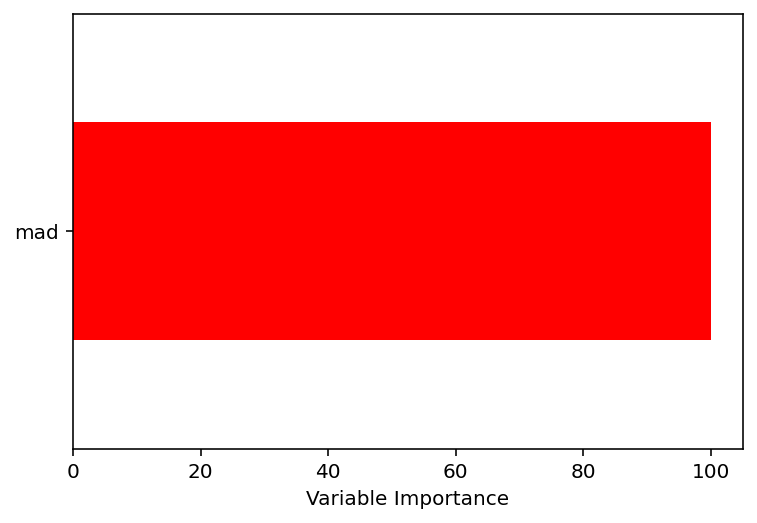

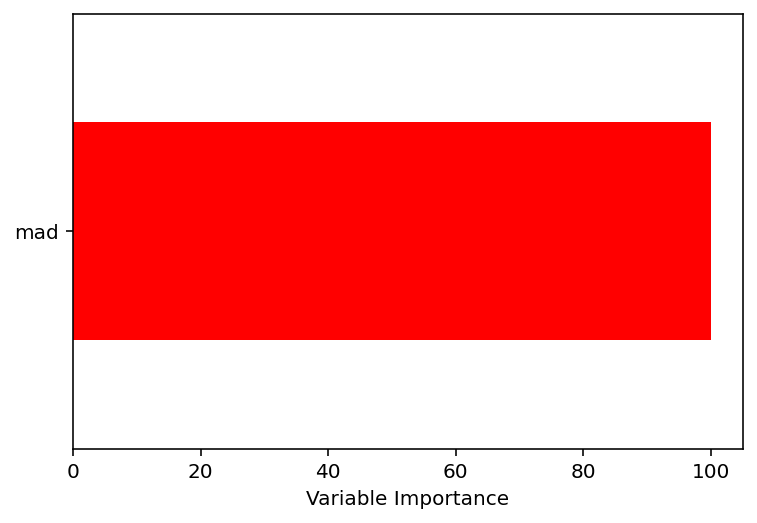

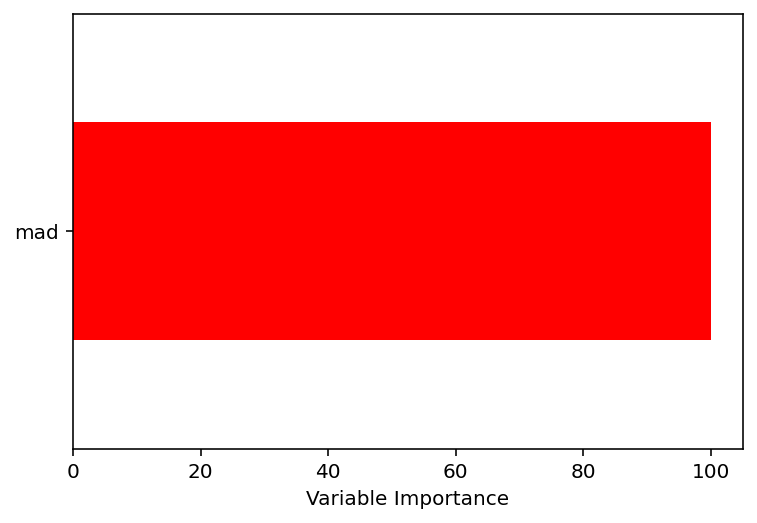

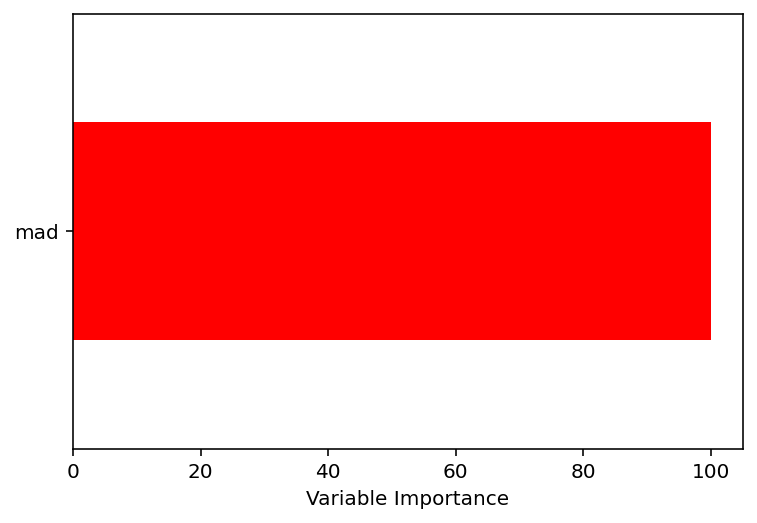

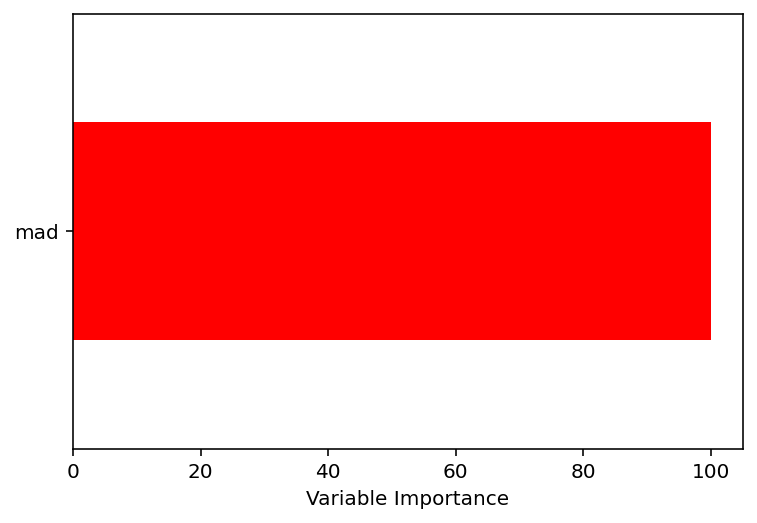

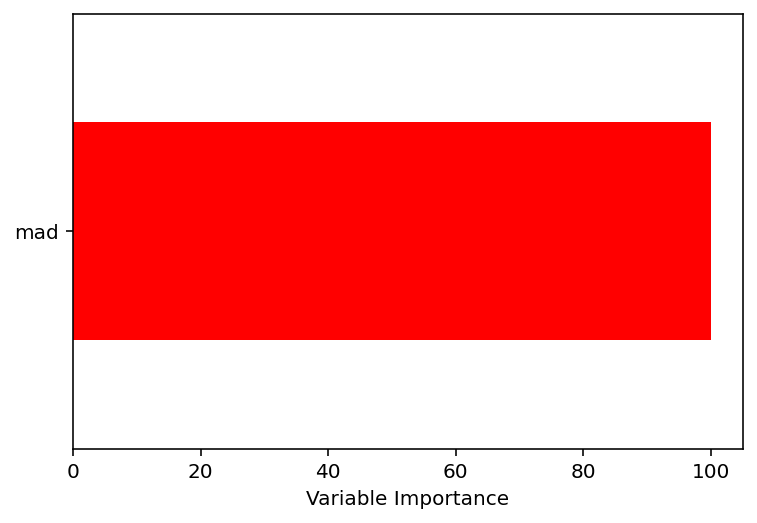

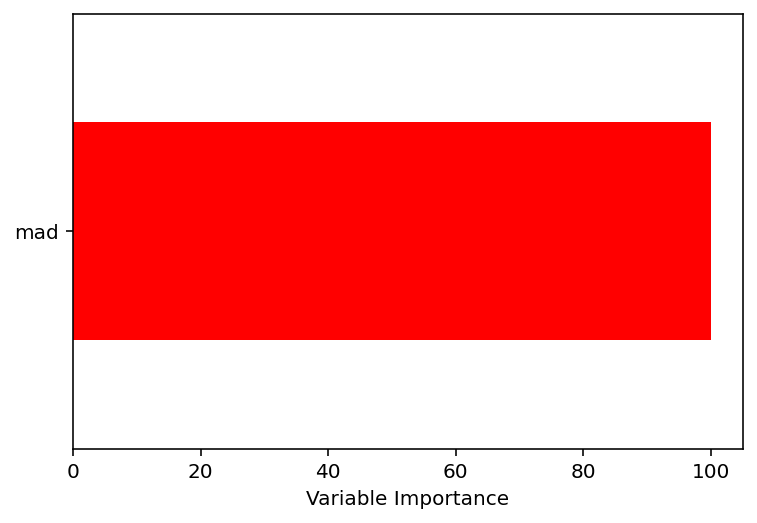

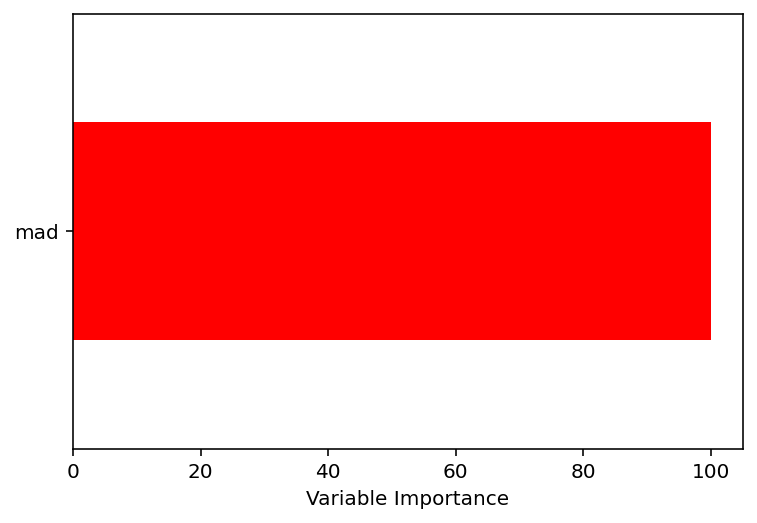

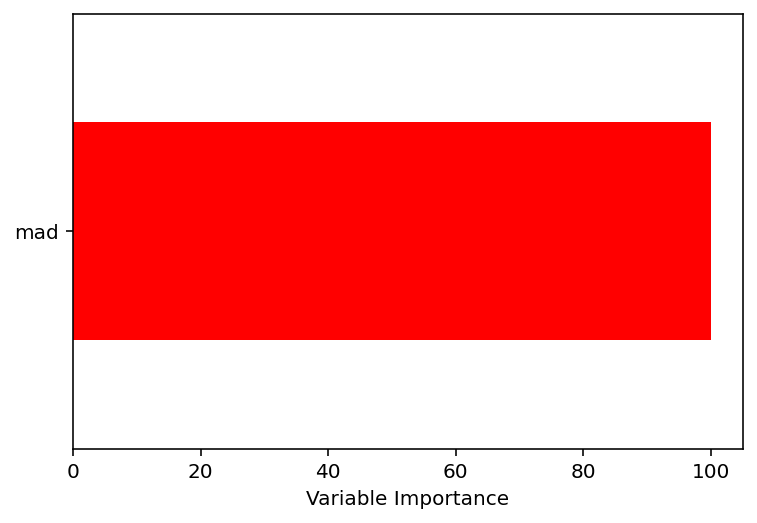

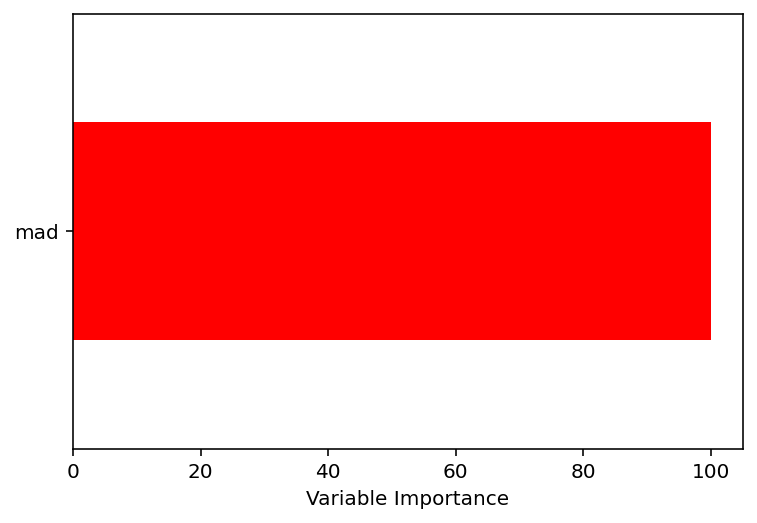

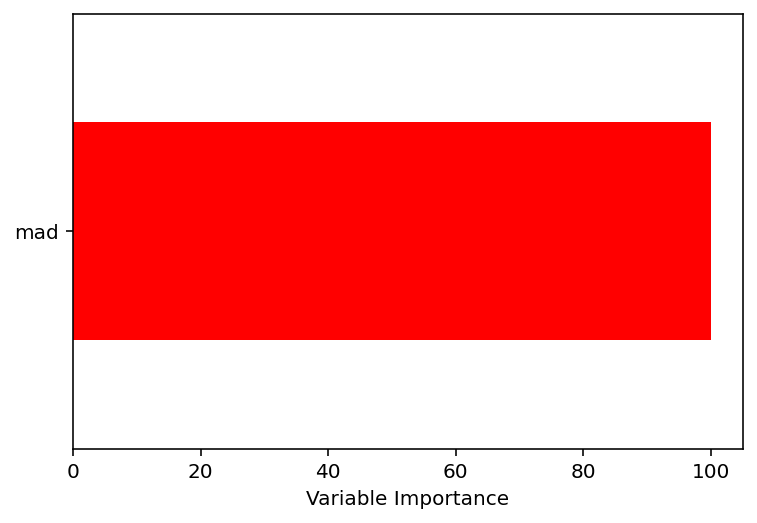

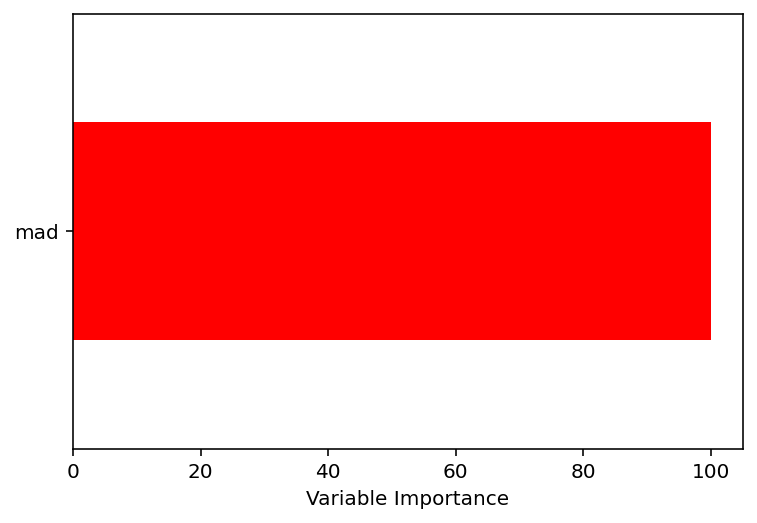

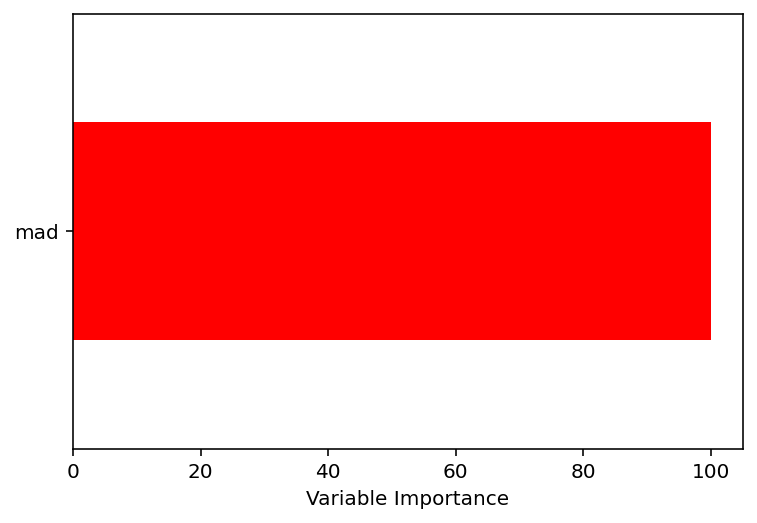

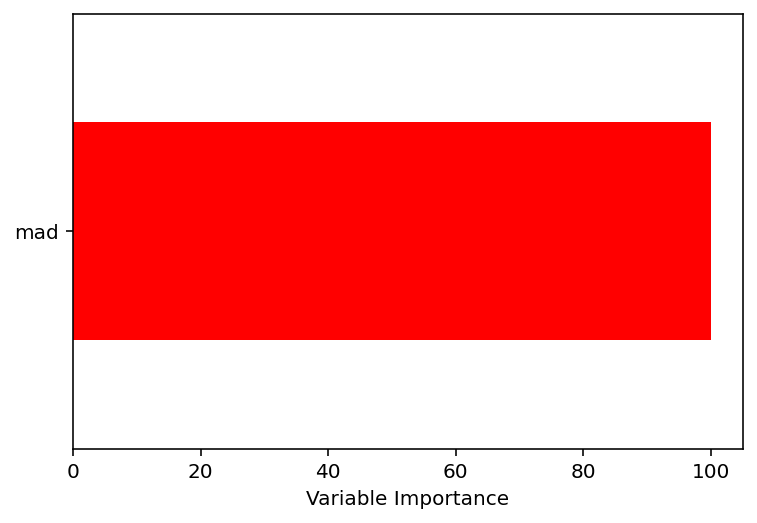

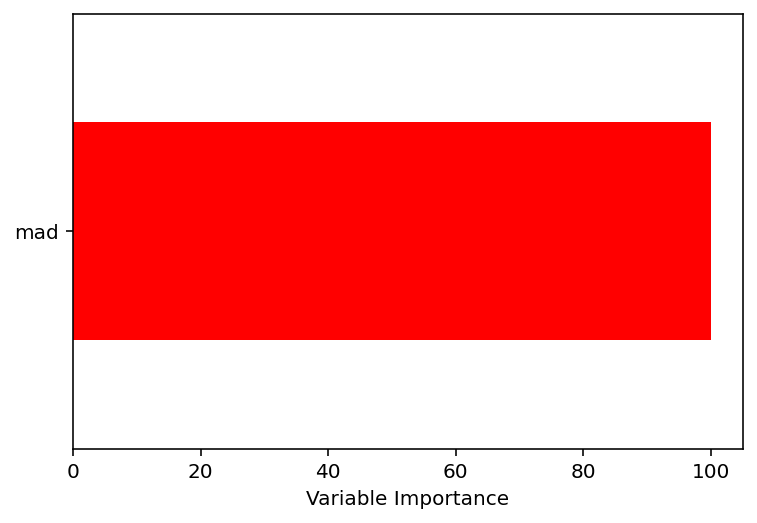

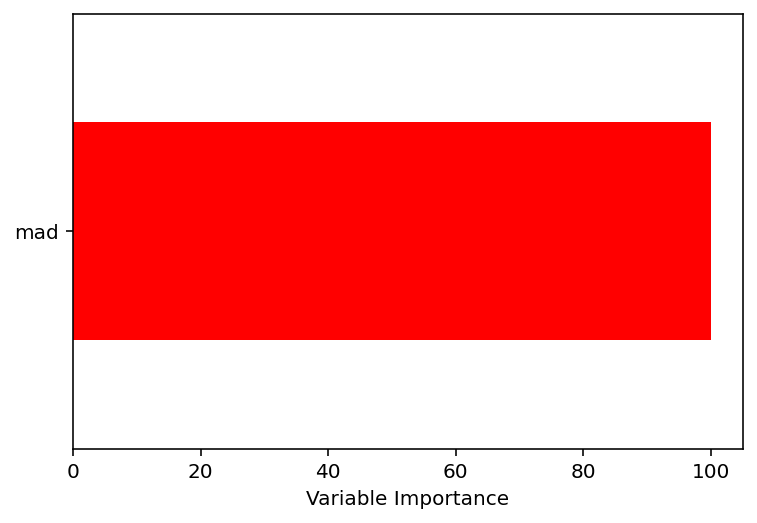

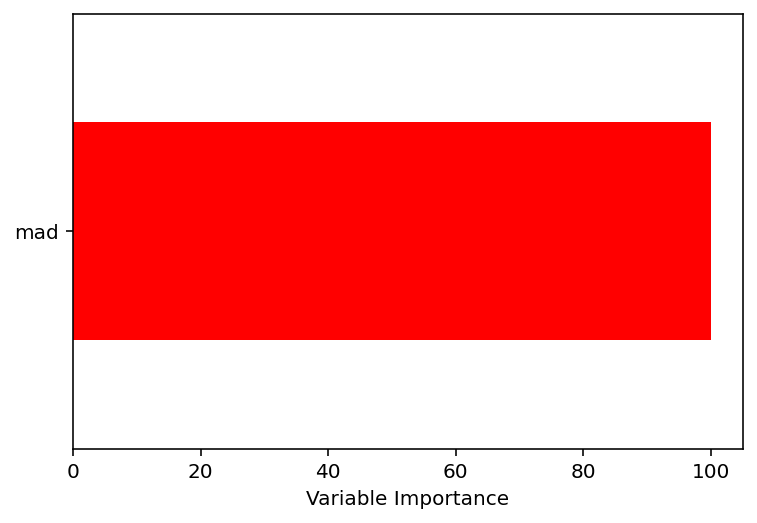

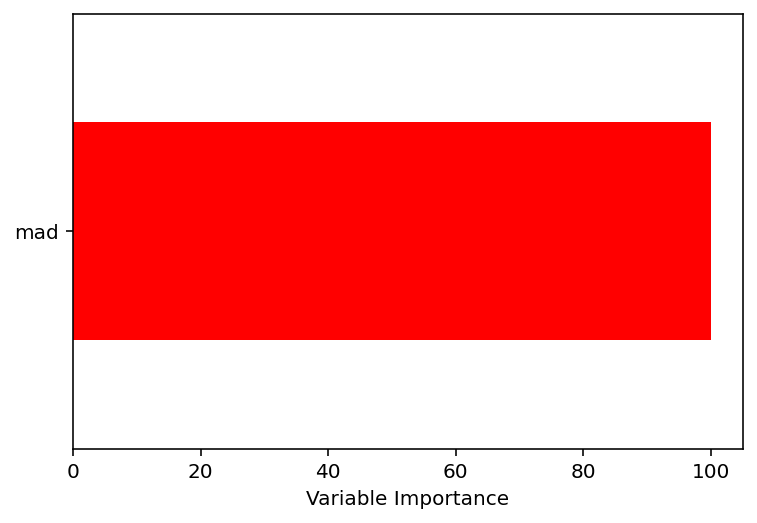

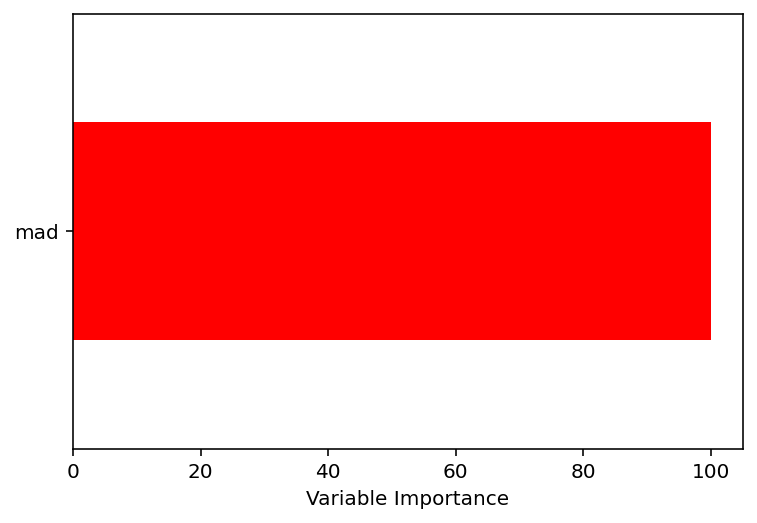

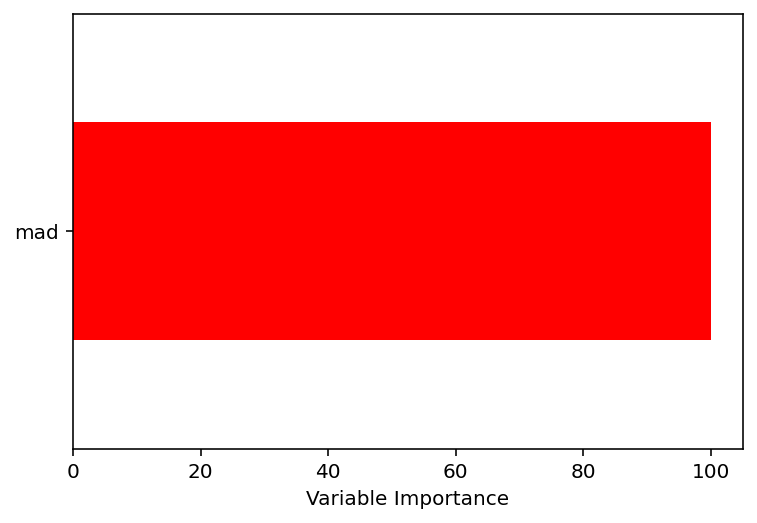

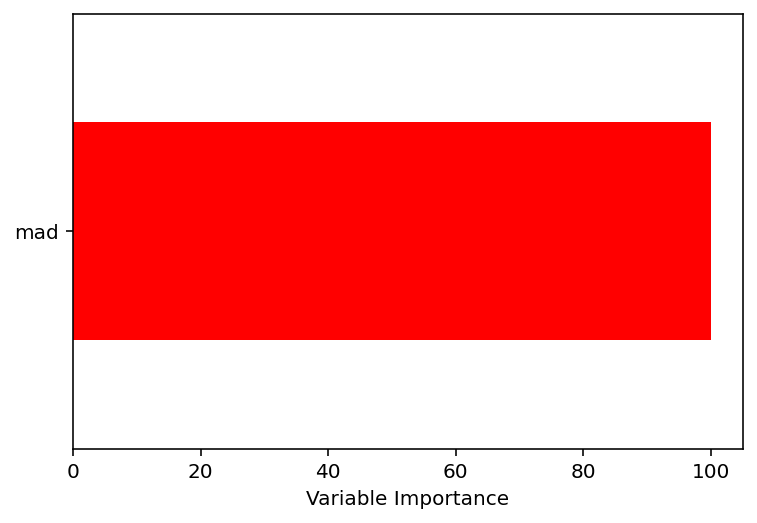

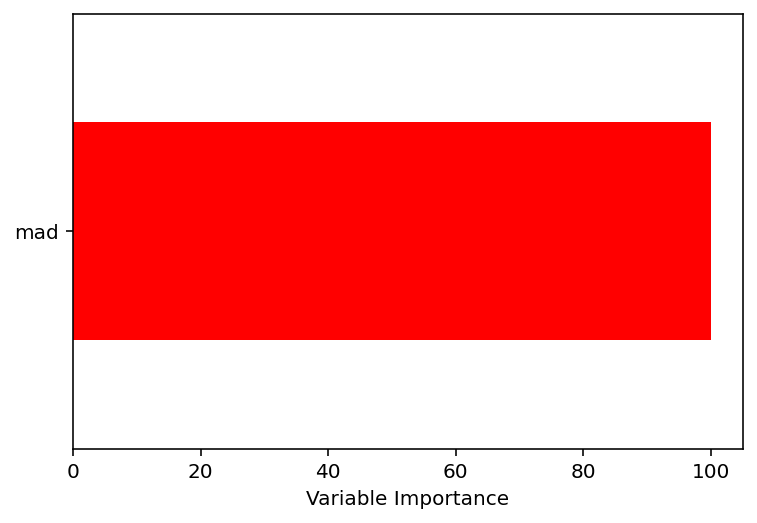

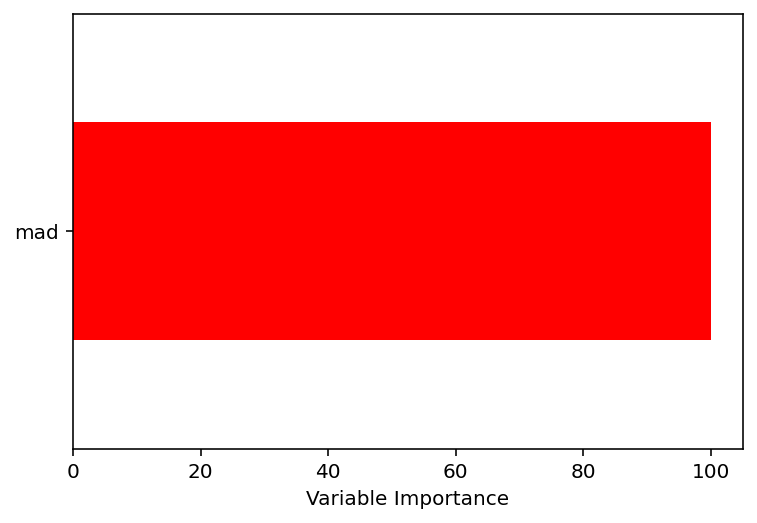

In [13]:
# LightGBM
lgbm = lightgbm.LGBMClassifier(learning_rate=0.09,max_depth=-5,random_state=42)

start_time = timeit.default_timer() #defines start time so computational time can be calculated

acc_score = []
Truth = []
Output = []
 
for train, test in tqdm(splits):
    X_train = X.iloc[train]
    y_train = y.iloc[train]

    X_test = X.iloc[test]
    y_test = y.iloc[test]
    
    # Create the LightGBM data containers
    model.fit(X_train,y_train,eval_set=[(X_test,y_test),(X_train,y_train)],
          eval_metric='logloss')

    pred_values = model.predict(X_test)
     
    acc = accuracy_score(y_test, pred_values)
    acc_score.append(acc)
    
    Truth.extend(y_test.values.reshape(y_test.shape[0])); ## it is a list
    Output.extend(pred_values); ## it is a list  
    
    #print(model.feature_importances_)
    Importance = pd.DataFrame({'Importance':(model.feature_importances_*100)[0:10]}, 
                          index = (X_train.columns)[0:10])
    Importance.sort_values(by = 'Importance', 
                       axis = 0, 
                       ascending = True).plot(kind = 'barh', 
                                              color = 'r')
    plt.xlabel('Variable Importance')
    plt.gca().legend_ = None
    #plt.savefig('plot1.png')


elapsed = timeit.default_timer() - start_time #gives total computation time
print("---Run time is %s seconds ---" % elapsed) #prints computation time
print()

print('Accuracy of each fold: \n {}'.format(acc_score))
print()
print('Avg accuracy : \n{}'.format(np.mean(acc_score))); 
print()
print('Std of accuracy : \n{}'.format(np.std(acc_score)))

cm = confusion_matrix(Truth, Output)
print(cm)
print("classification report: ")
print(classification_report(Truth, Output))

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

performance_dict['Avg Accuracy'].append(np.mean(acc_score))
performance_dict['Std Accuracy'].append(np.std(acc_score))
performance_dict['Sensitivity'].append(sensitivity)
performance_dict['Specificity'].append(specificity)
performance_dict['Precision'].append(precision)
performance_dict['F1 score'].append(f1_score)
performance_dict['Run time'].append(elapsed)

 87%|███████████████████████████████████████████████████████████████████████▎          | 20/23 [00:10<00:01,  1.87it/s]C:\Users\lms-puvvalat\.conda\envs\afib\lib\site-packages\pandas\plotting\_matplotlib\core.py:386: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:12<00:00,  1.83it/s]


---Run time is 12.58425289997831 seconds ---

Accuracy of each fold: 
 [0.8533151059466849, 0.9293272497815745, 0.9695324283559578, 0.5918023582257159, 0.964702926767994, 0.9161070559610706, 0.8950907868190988, 0.9134064495007366, 0.9034358047016274, 0.6778966838419871, 0.9727401591974703, 0.8617591152583377, 0.7197167755991285, 0.9082133006435795, 0.5569077306733167, 0.8091122492530943, 0.8915742426750538, 0.984177654406662, 0.5084161427702292, 0.9443710359408034, 0.969666019814115, 0.8897614013893084, 0.966888754290329]

Avg accuracy : 
0.852083540513647

Std of accuracy : 
0.13850688028077796
[[82937 19948]
 [ 8656 76016]]
classification report: 
              precision    recall  f1-score   support

           0       0.91      0.81      0.85    102885
           1       0.79      0.90      0.84     84672

    accuracy                           0.85    187557
   macro avg       0.85      0.85      0.85    187557
weighted avg       0.85      0.85      0.85    187557



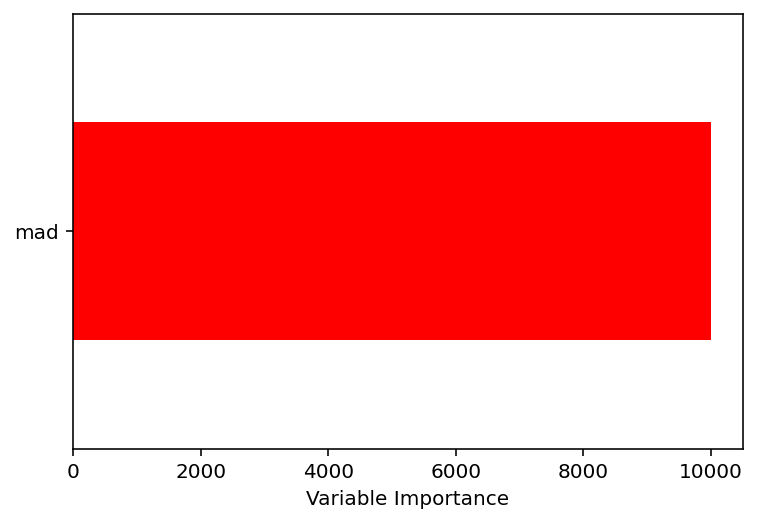

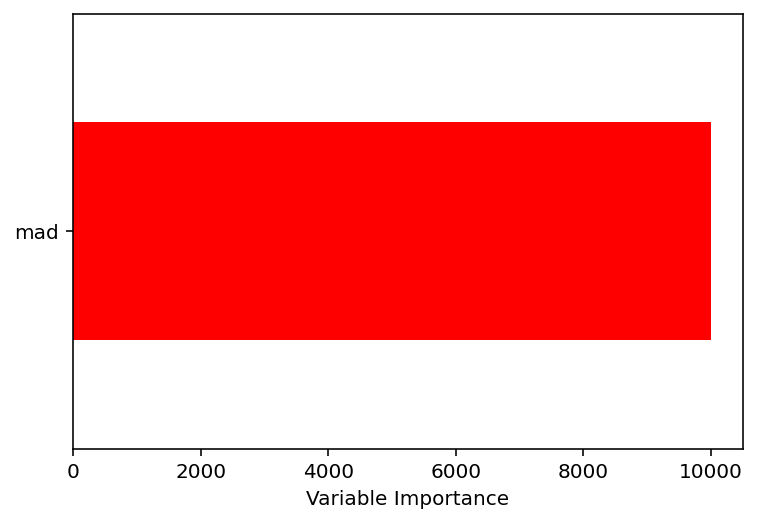

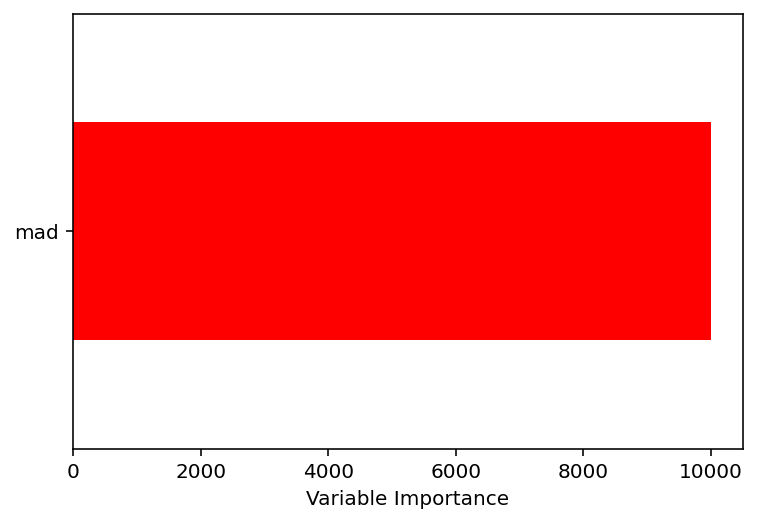

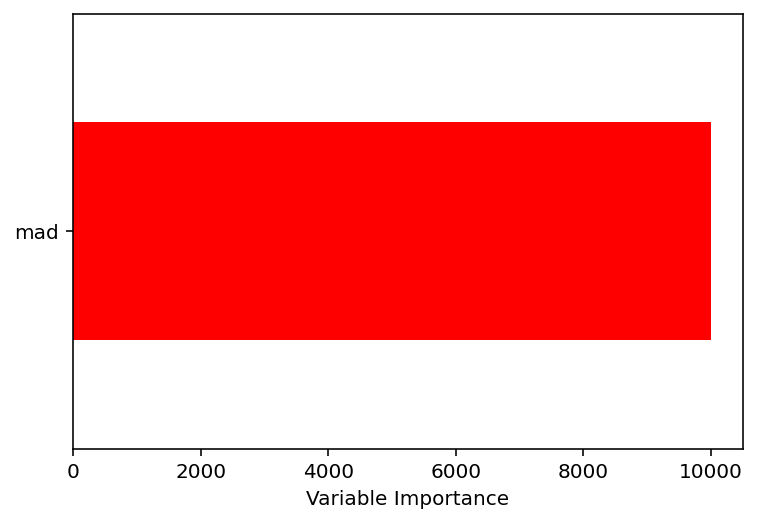

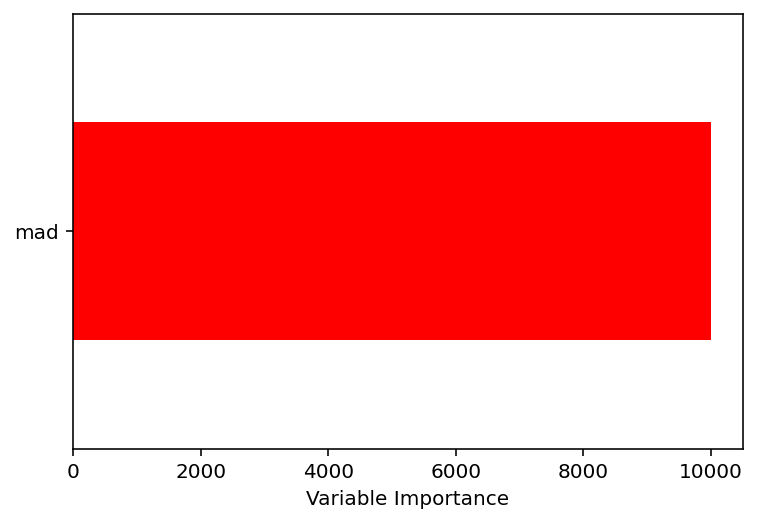

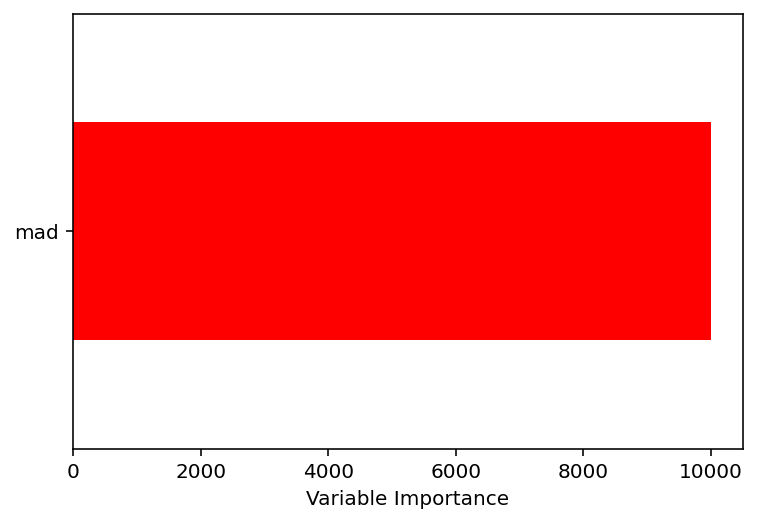

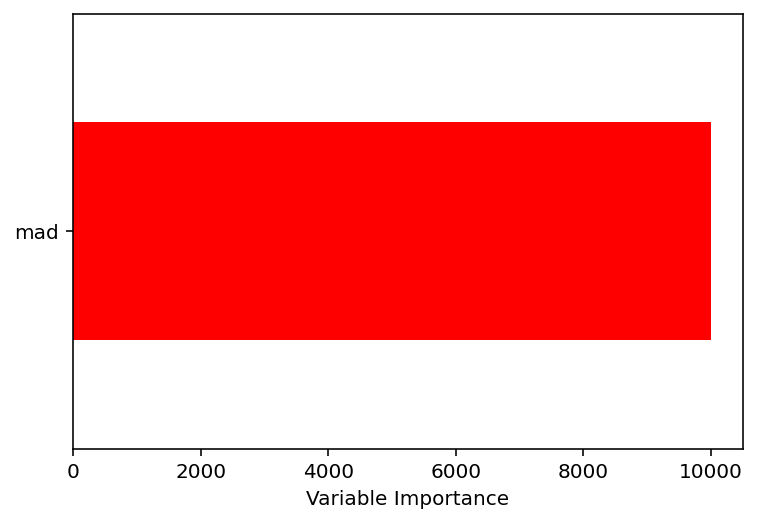

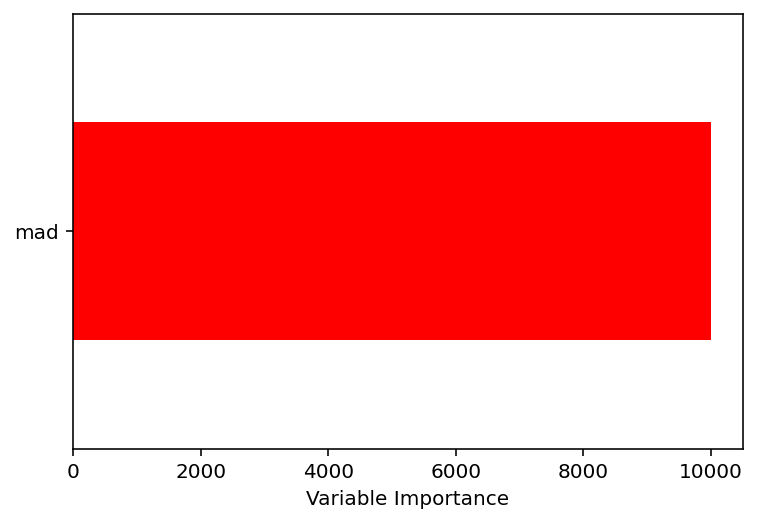

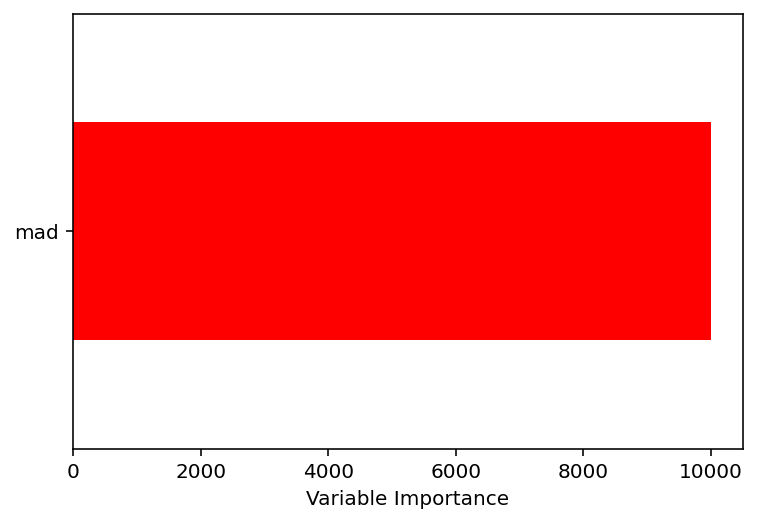

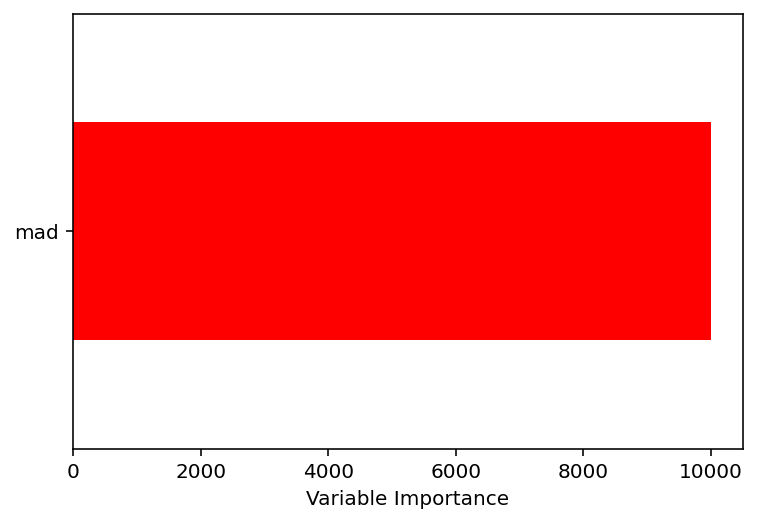

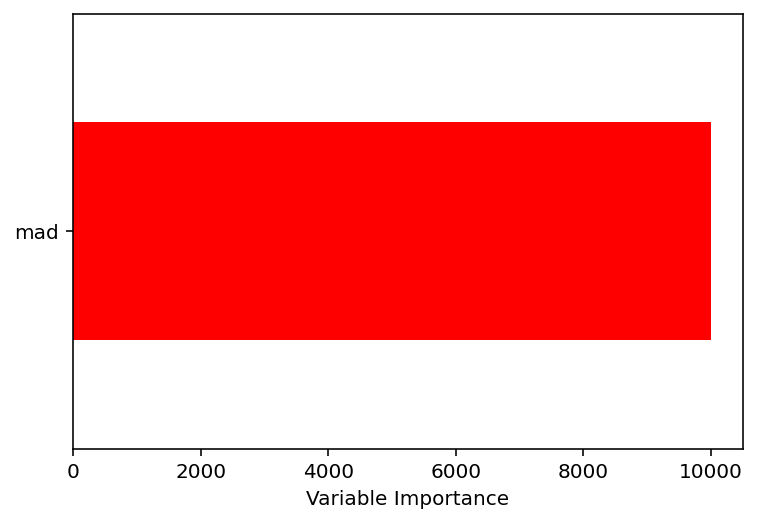

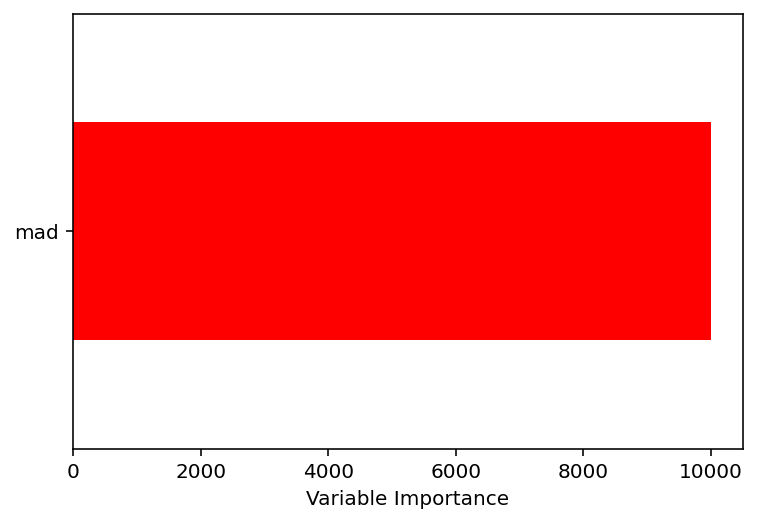

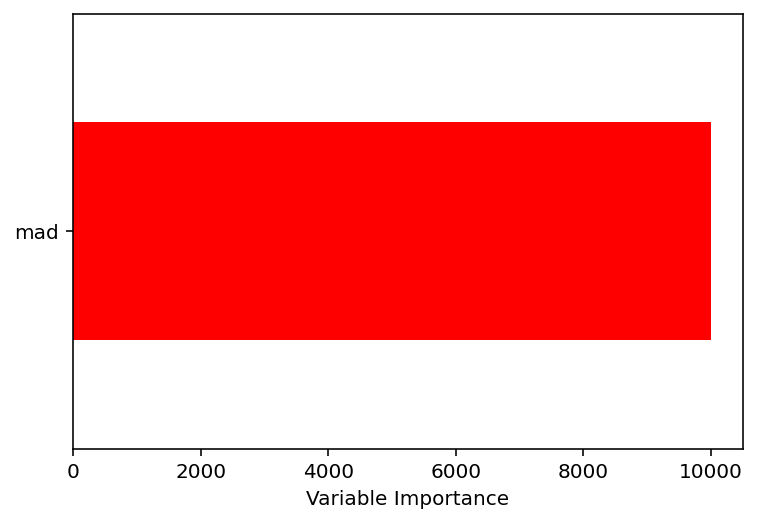

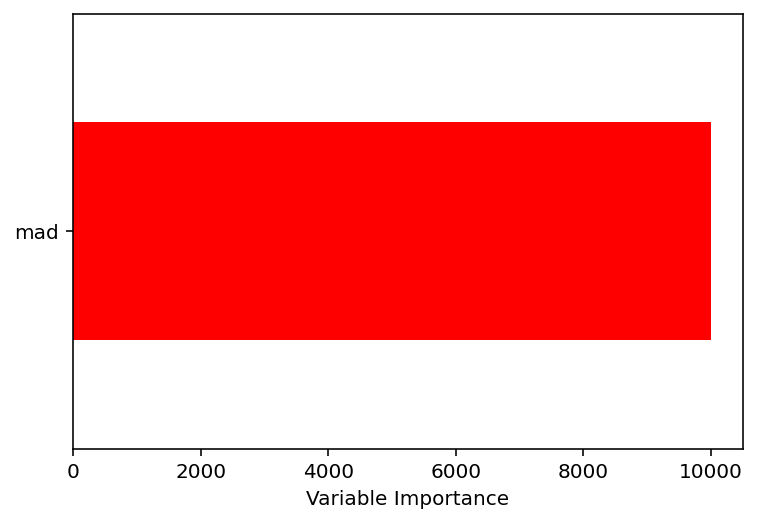

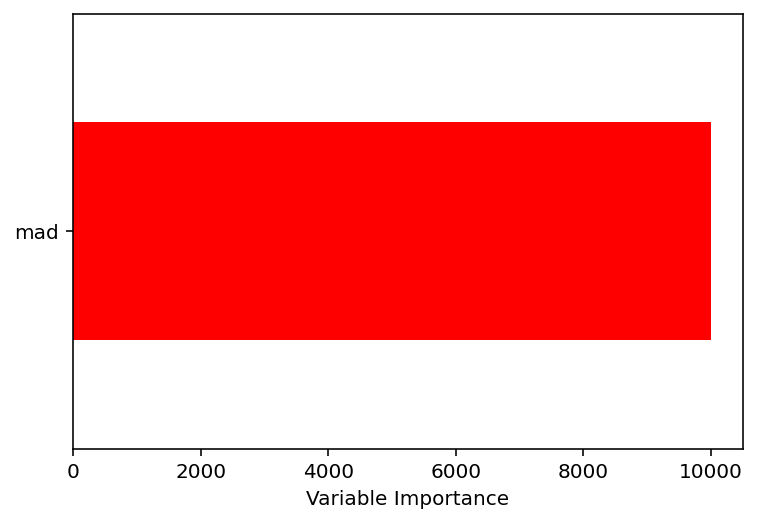

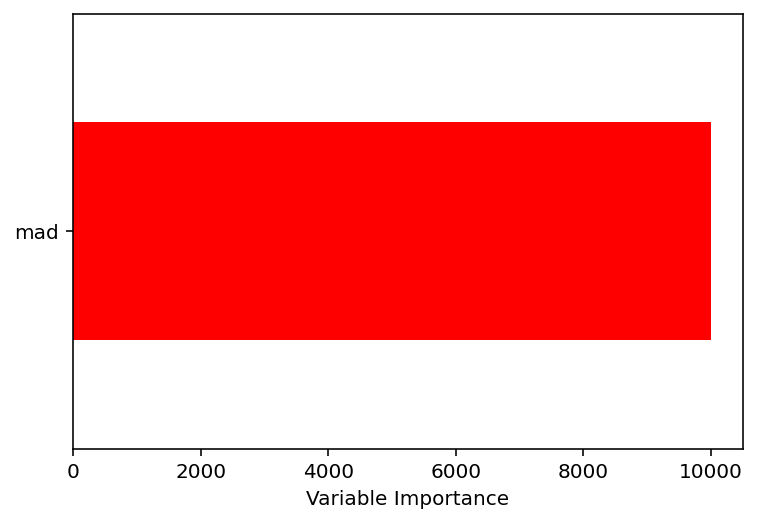

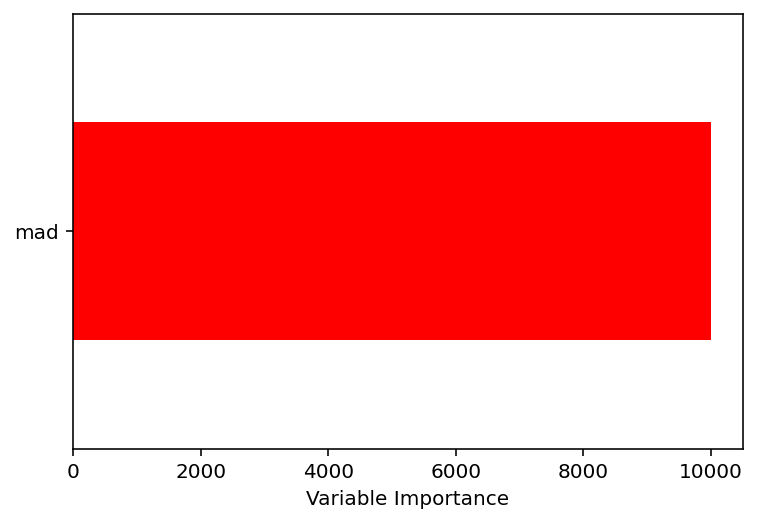

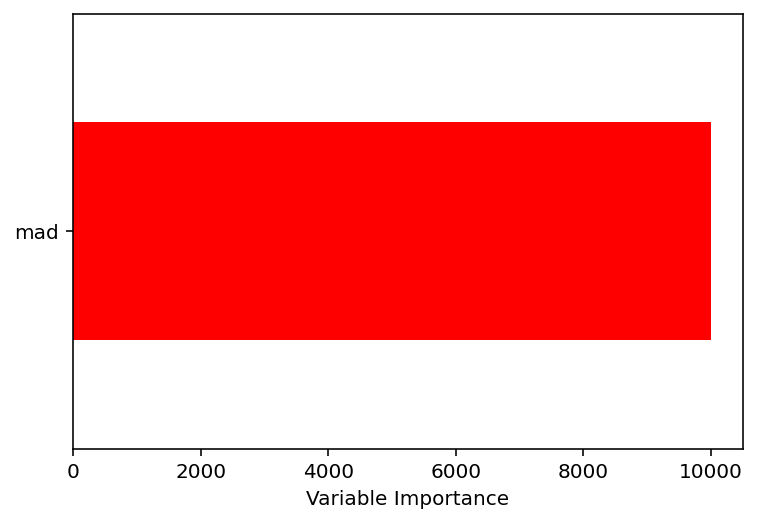

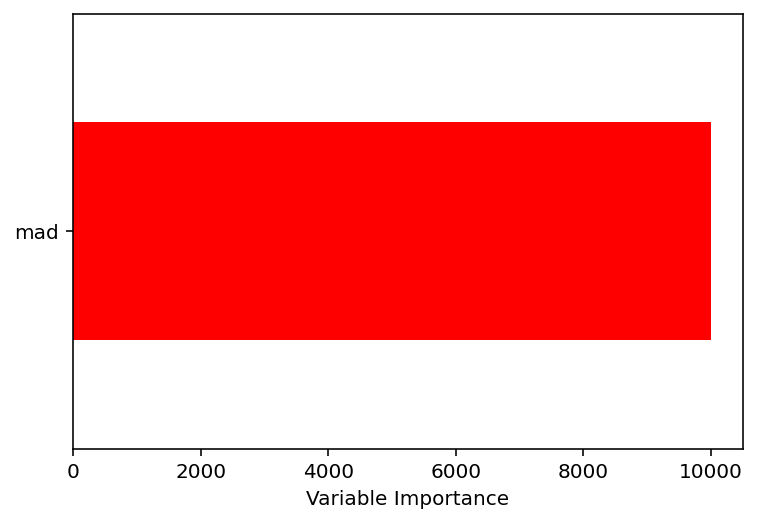

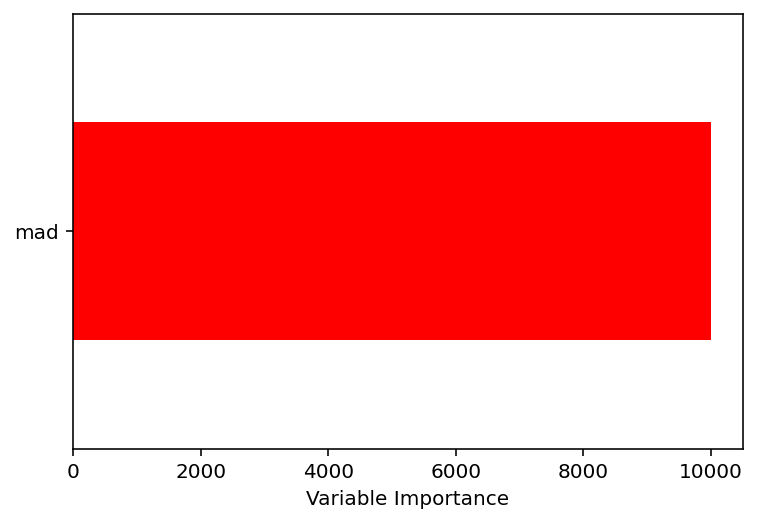

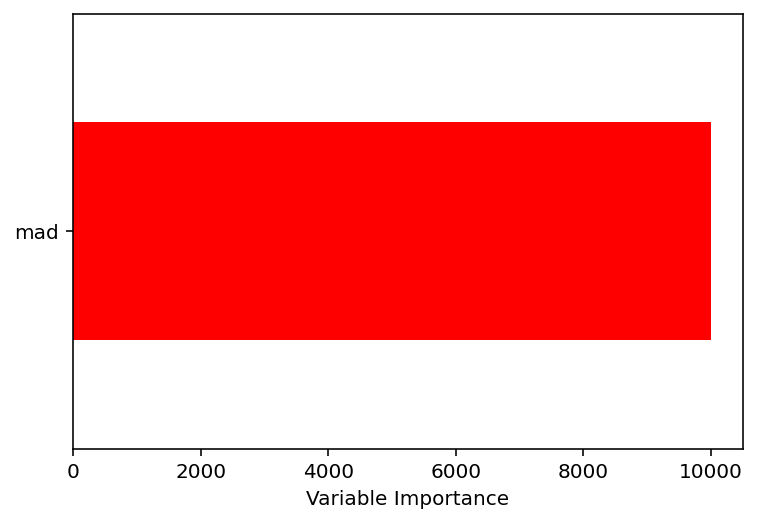

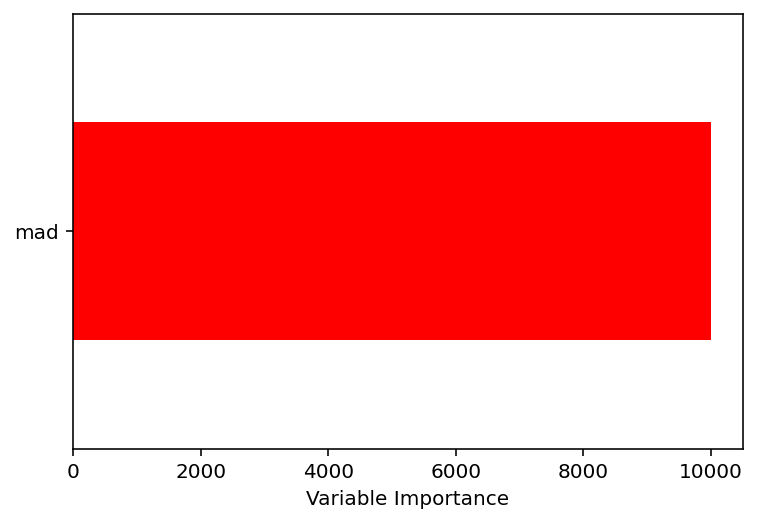

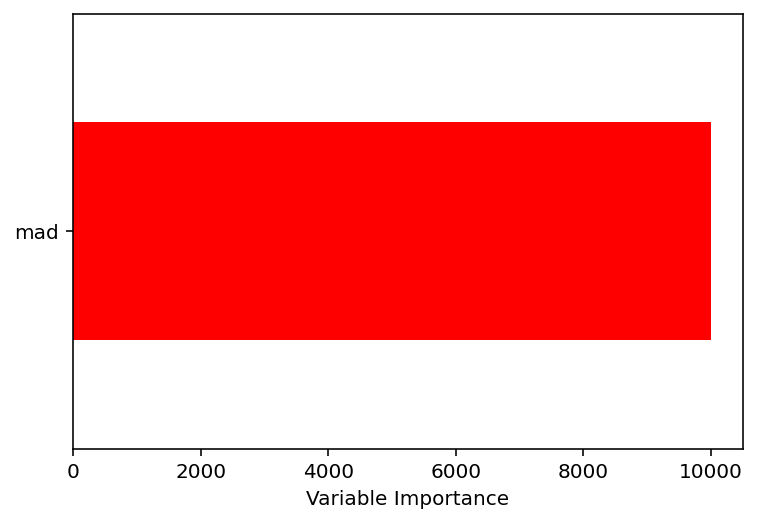

In [14]:
# CatBoost
start_time = timeit.default_timer() #defines start time so computational time can be calculated

acc_score = []
Truth = []
Output = []
 
for train, test in tqdm(splits):
    X_train = X.iloc[train]
    y_train = y.iloc[train]

    X_test = X.iloc[test]
    y_test = y.iloc[test]
    
    # Create CatBoost model
    model = CatBoostClassifier(iterations=100,
                           depth=4,
                           learning_rate=0.1,
                           loss_function='Logloss')
    # train the model
    model.fit(X_train, y_train, verbose=False)
    
    # make the prediction using the resulting model
    pred_values = model.predict(X_test)
    #preds_proba = model.predict_proba(test_data)
    #print("class = ", preds_class)
    #print("proba = ", preds_proba)
     
    acc = accuracy_score(y_test, pred_values)
    acc_score.append(acc)
    
    Truth.extend(y_test.values.reshape(y_test.shape[0])); ## it is a list
    Output.extend(pred_values); ## it is a list  
    
    #print(model.feature_importances_)
    Importance = pd.DataFrame({'Importance':(model.feature_importances_*100)[0:10]}, 
                          index = (X_train.columns)[0:10])
    Importance.sort_values(by = 'Importance', 
                       axis = 0, 
                       ascending = True).plot(kind = 'barh', 
                                              color = 'r')
    plt.xlabel('Variable Importance')
    plt.gca().legend_ = None
    #plt.savefig('plot1.png')


elapsed = timeit.default_timer() - start_time #gives total computation time
print("---Run time is %s seconds ---" % elapsed) #prints computation time
print()

print('Accuracy of each fold: \n {}'.format(acc_score))
print()
print('Avg accuracy : \n{}'.format(np.mean(acc_score))); 
print()
print('Std of accuracy : \n{}'.format(np.std(acc_score)))

cm = confusion_matrix(Truth, Output)
print(cm)
print("classification report: ")
print(classification_report(Truth, Output))

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

performance_dict['Avg Accuracy'].append(np.mean(acc_score))
performance_dict['Std Accuracy'].append(np.std(acc_score))
performance_dict['Sensitivity'].append(sensitivity)
performance_dict['Specificity'].append(specificity)
performance_dict['Precision'].append(precision)
performance_dict['F1 score'].append(f1_score)
performance_dict['Run time'].append(elapsed)

In [15]:
performance_df = pd.DataFrame(performance_dict)
performance_df

,Avg Accuracy,Std Accuracy,Sensitivity,Specificity,Precision,F1 score,Run time
0,0.865465,0.130060,0.808855,0.946757,0.958236,0.877231,87.348303
1,0.854123,0.136034,0.808855,0.899577,0.907296,0.855252,101.526440
2,0.852084,0.138507,0.806114,0.897770,0.905495,0.852919,12.584253
